## Advanced Lane Detection

## Goals and Objectives

The goals / steps of this project are the following:

-  Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
-  Apply a distortion correction to raw images.
-  Use color transforms, gradients, etc., to create a thresholded binary image.
-  Apply a perspective transform to rectify binary image ("birds-eye view").
-  Detect lane pixels and fit to find the lane boundary.
-  Determine the curvature of the lane and vehicle position with respect to center.
-  Warp the detected lane boundaries back onto the original image.
-  Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import glob
import pickle
import math
%matplotlib inline


## Camera Calibration

    The images in the calibration have different sizes. I have used range of values for nx and ny to cover all the scenarios. The constants from the calibration are saved; for use later in the pipeline

In [2]:
def calibrate(path, out_dir):
    images = glob.glob(path)
    obj_points=[]
    img_points=[]
    for filename in images:
        for ny in [5,6]:
            for nx in [6,7,8,9]:
                img = cv2.imread(filename)
                # Convert to gray
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                # Find the chessboard corners
                ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
                obj_point = np.zeros((nx*ny, 3), np.float32)
                # Transform this to 2x2 array
                obj_point[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
                # If successful in finding cornere
                if ret:
                    obj_points.append(obj_point)
                    img_points.append(corners)
                    chess_board_corners= cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
                    image_name = os.path.split(filename)[1]
                    out_image_name = out_dir + 'nx_' +str(nx) +'ny_' + str(ny) + '_' + image_name
                    cv2.imwrite(out_image_name, img)
                    break
        cv2.destroyAllWindows()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)
    return mtx, dist

out_dir = 'output_images/corners_found/'
path = os.path.join("camera_cal", "*.jpg")
mtx, dist = calibrate(path, out_dir)
# Save the points for use later
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_dist_pickle.p", "wb" ) )

 ## Images with corners
     

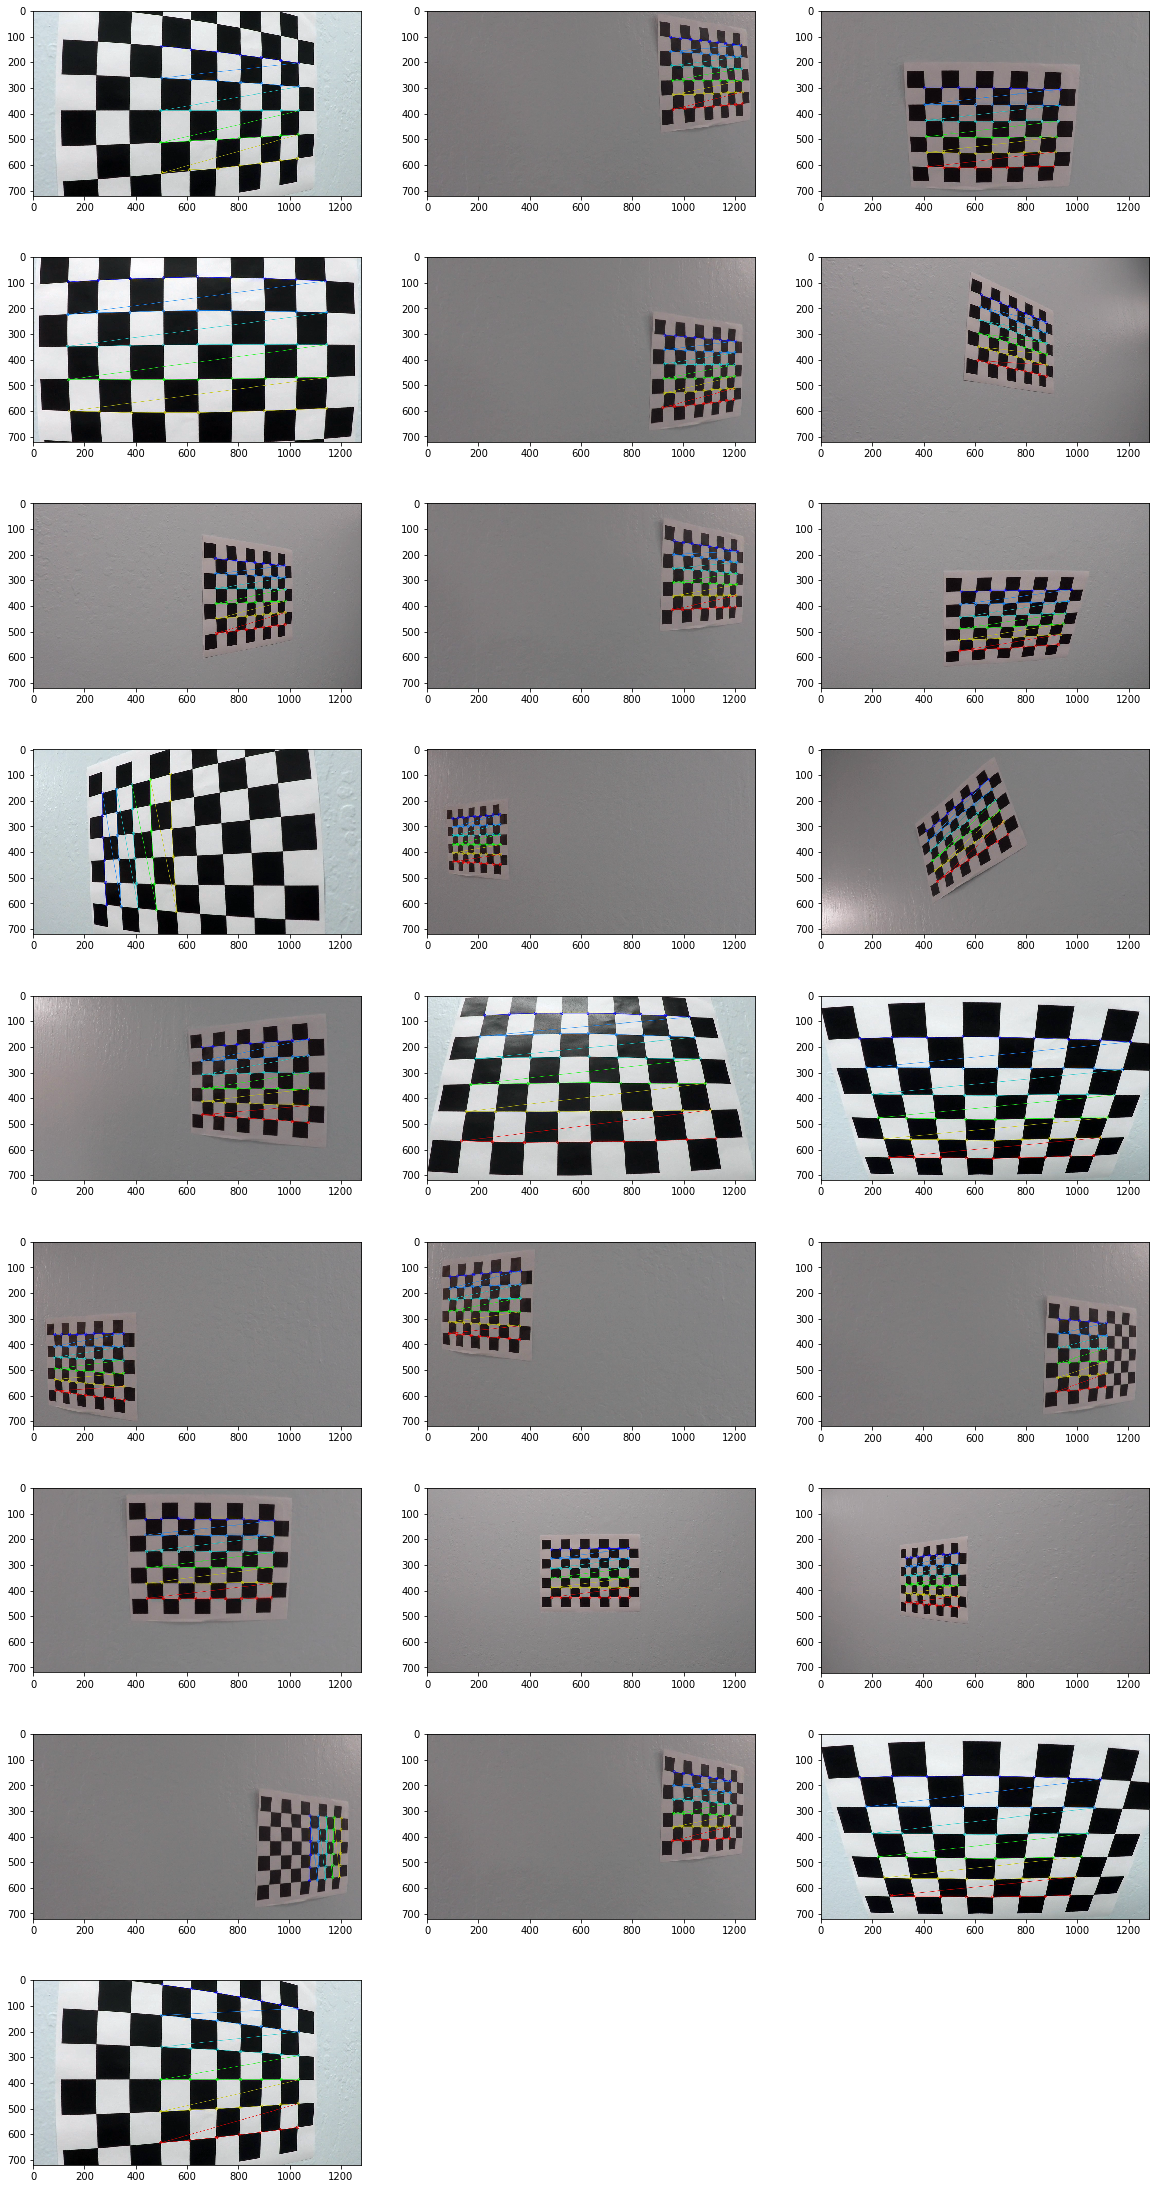

In [7]:
path = os.path.join('output_images/corners_found/', "*.jpg")
images = glob.glob(path)
t_images = len(images)
plt.figure(figsize=(20,40))
idx = 1
for fname in images:
    img = cv2.imread(fname)
    plt.subplot(math.ceil(t_images/3), 3, idx)
    plt.imshow(img)
    idx+=1

## Undistort

([], <a list of 0 Text yticklabel objects>)

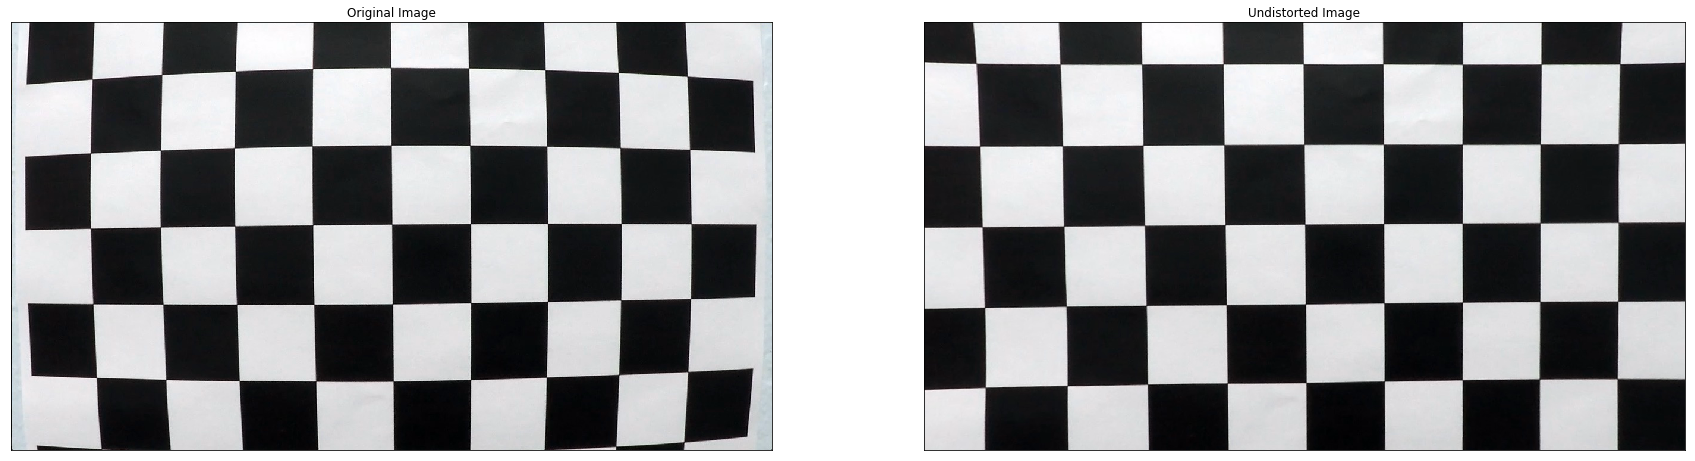

In [119]:
import pickle
def undistort(img, mtx, dist):
    # Undistort
    return cv2.undistort(img, mtx, dist, None, mtx)

# Read the values from pickle
with open('camera_dist_pickle.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
test_image_path = os.path.join('camera_cal', 'calibration1.jpg')
test_image = cv2.imread(test_image_path)
undistorted_img = undistort(test_image, mtx, dist)

out_dir = 'output_images/'

plt.figure(figsize=(30,40))
plt.subplot(121)
plt.imshow(test_image)
plt.title('Original Image')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imsave(out_dir+'undistorted.jpg', undistorted_img)
plt.imshow(undistorted_img)
plt.title('Undistorted Image')
plt.xticks([])
plt.yticks([])

## Apply distortion to raw images

([], <a list of 0 Text yticklabel objects>)

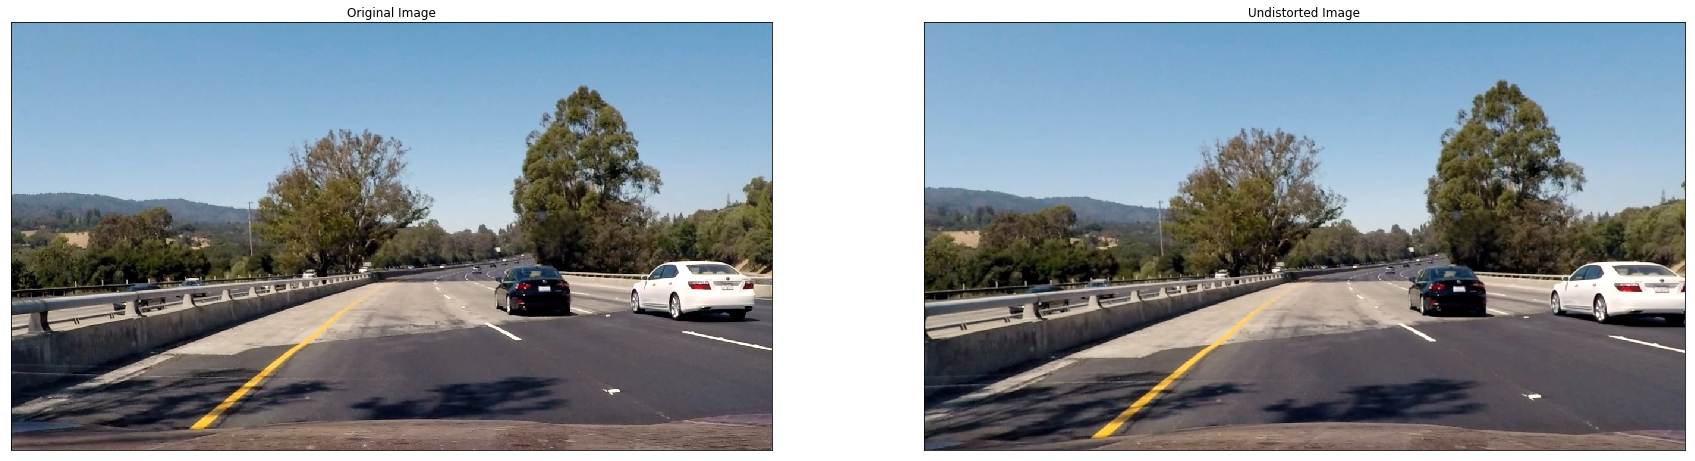

In [120]:
test_image = plt.imread('test_images/test4.jpg')
undistorted_img = undistort(test_image, mtx, dist)


plt.figure(figsize=(30,40))
plt.subplot(121)
plt.imshow(test_image)
plt.title('Original Image')
plt.xticks([])
plt.yticks([])


plt.subplot(122)
plt.imsave(out_dir+'test4_undist.jpg', undistorted_img)
plt.imshow(undistorted_img)
plt.title('Undistorted Image')
plt.xticks([])
plt.yticks([])

## Create a threshold binary image

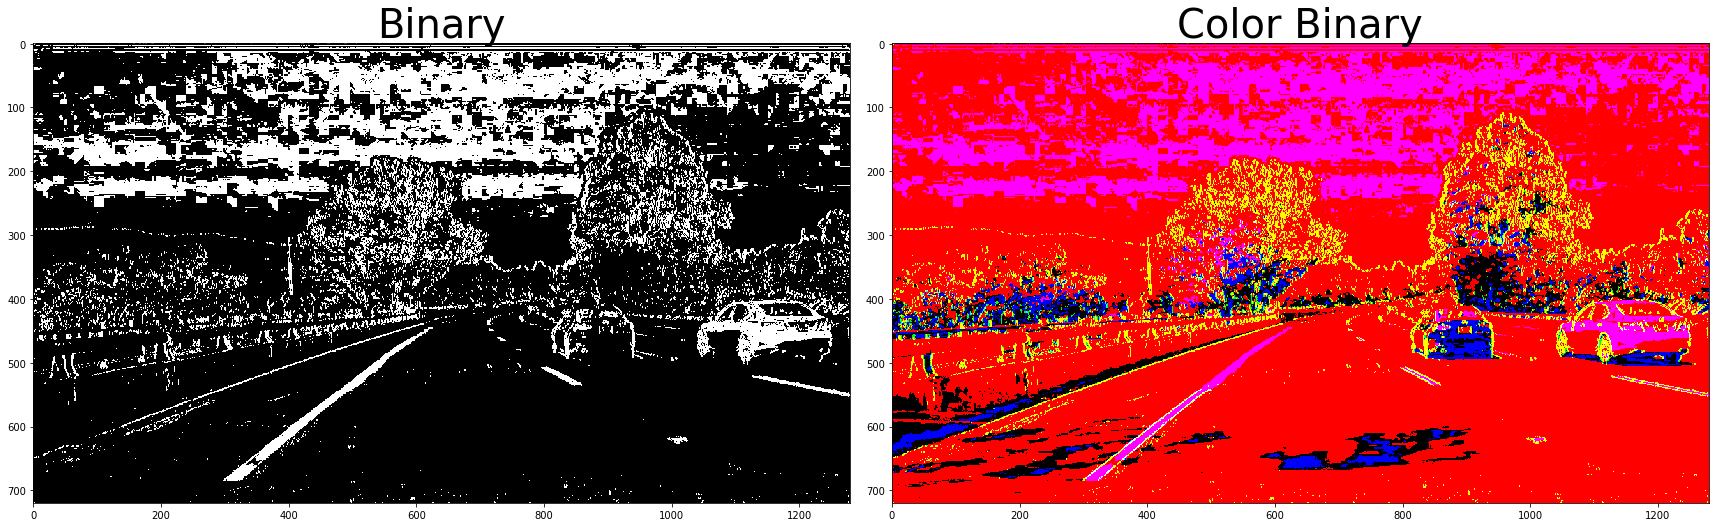

In [121]:
def threshold_binarize(img, s_thresh=(120, 255), sx_thresh=(20, 255),l_thresh=(40,255)):
    img = np.copy(img)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
     # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    # Threshold saturation
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Thershold Light
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    # color channels
    color_binary = np.dstack(( l_binary, sxbinary, s_binary)).astype('uint8') * 255
    binary = np.zeros_like(sxbinary)
    binary[((l_binary == 1) & (s_binary == 1) | (sxbinary==1))] = 1
    binary = 255*np.dstack((binary,binary,binary)).astype('uint8') 
    return binary, color_binary


img = plt.imread('test_images/test4.jpg')

shape = img.shape
binary,color_binary = threshold_binarize(img)
plt.imsave(out_dir+'binary.jpg',binary)
plt.imsave(out_dir+'color_binary.jpg',color_binary)

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(binary, cmap='gray')
ax1.set_title('Binary', fontsize=40)

ax2.imshow(color_binary)
ax2.set_title('Color Binary', fontsize=40)



## Perspective Transform

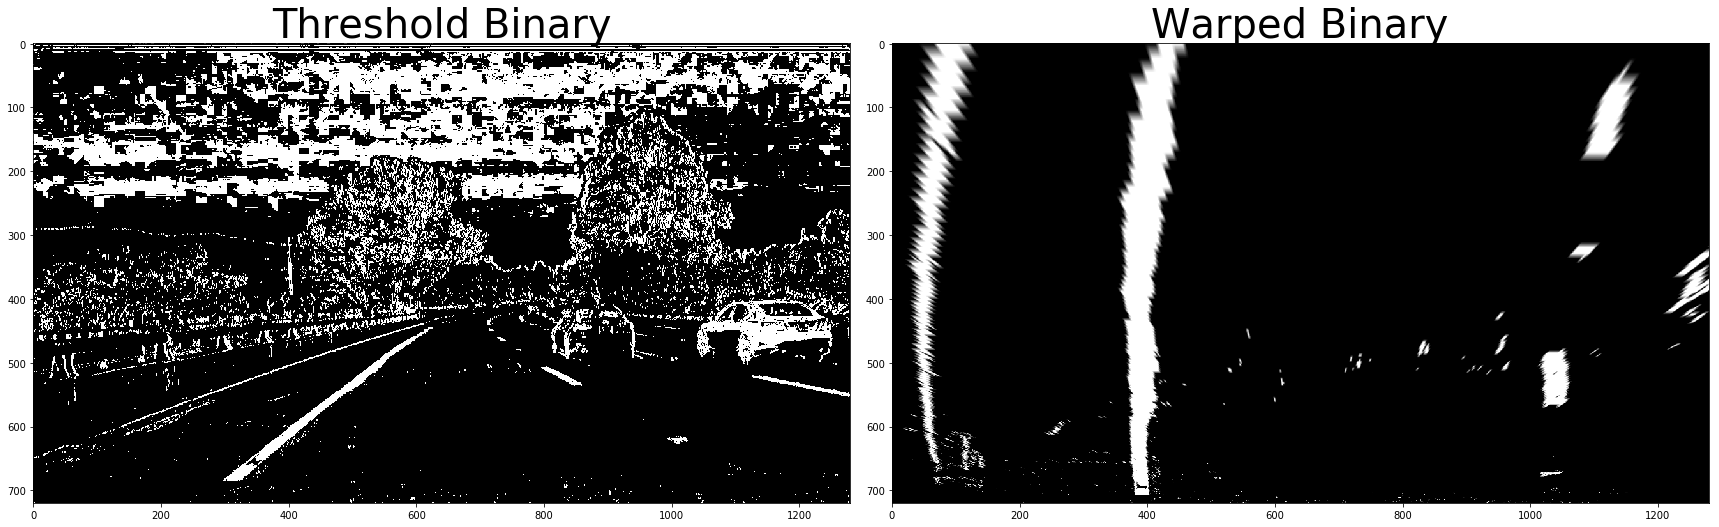

In [122]:
def warp(img, bird_view= True):
    corners = np.float32([[190,720],[589,457],[698,457],[1145,720]])
    new_top_left=np.array([corners[0,0],0])
    new_top_right=np.array([corners[3,0],0])
    offset=[150,0]
    
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([corners[0],corners[1],corners[2],corners[3]])
    dst = np.float32([corners[0]+offset,new_top_left+offset,new_top_right-offset ,corners[3]-offset])    
    if bird_view:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)    
    return warped, M

img = plt.imread('test_images/test4.jpg')

binary,color_binary = threshold_binarize(img)
binary_warped,_ = warp(binary)

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(binary, cmap='gray')
ax1.set_title('Threshold Binary', fontsize=40)

plt.imsave(out_dir+'binary_warped.jpg', binary_warped)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Warped Binary', fontsize=40)


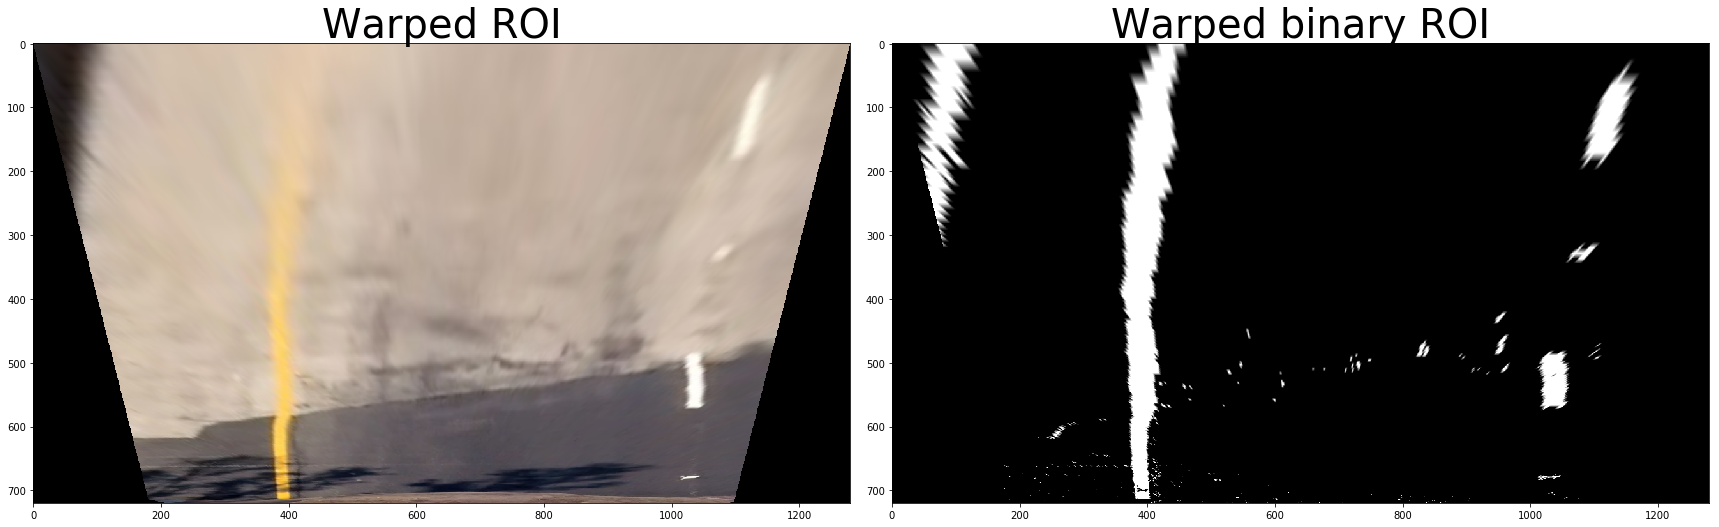

In [123]:
def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """    
    shape = img.shape
    vertices = np.array([[(0,0),(shape[1],0),(shape[1],0),(6*shape[1]/7,shape[0]),
                      (shape[1]/7,shape[0]), (0,0)]],dtype=np.int32)

    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def warp_pipeline(img):
    undist = undistort(img, mtx, dist)    
    result,_ = warp(undist)
    result = region_of_interest(result)
    return result
    
def warp_binarize_pipeline(img):
    undist = undistort(img, mtx, dist)
    binary,_  = threshold_binarize(undist)
    result,_  = warp(binary)
    result = region_of_interest(result)
    return result 

warp_roi = warp_pipeline(img)
warp_binary_roi = warp_binarize_pipeline(img)

plt.imsave(out_dir+'warp_roi.jpg',warp_roi)
plt.imsave(out_dir+'warp_binary_roi.jpg',warp_binary_roi)

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(warp_roi)
ax1.set_title('Warped ROI', fontsize=40)

ax2.imshow(warp_binary_roi)
ax2.set_title('Warped binary ROI', fontsize=40)

## Fit Lane Boundary

(720, 0)

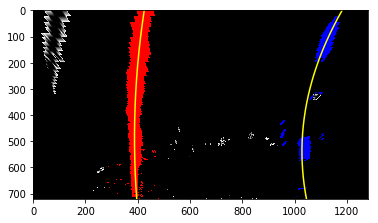

In [124]:
# Take a histogram of the bottom half of the image
# Sum all the values from middle to bottom. y -axis
binary_warped = warp_binary_roi[:,:,0]
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
# argmax returns the position of the max value from start (0 each time) 
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imsave(out_dir+'lanes.jpg', out_img)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


In [114]:
def process_firstframe(binary_warped):
    if len(binary_warped.shape) > 2:
        binary_warped = binary_warped[:,:,0]
    # Take a histogram of the bottom half of the image
    # Sum all the values from middle to bottom. y -axis
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    # argmax returns the position of the max value from start (0 each time) 
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        # cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        # cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit

def process_nextframes(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit


def pipeline(img):
    global line
    # Undistort the image
    # Read the values from pickle
    with open('camera_dist_pickle.p', mode='rb') as f:
        dist_pickle = pickle.load(f)
        mtx = dist_pickle["mtx"]
        dist = dist_pickle["dist"]
    undistorted = undistort(img, mtx, dist)
    # Color and gradient binary
    threshold_binary,_ = threshold_binarize(undistorted)
    # perspective transform
    binary_warped, M = warp(threshold_binary)
    # region of interest
    binary_warped_roi = region_of_interest(binary_warped)
    if line.first_frame_processed:
        left_fit, right_fit = process_nextframes(binary_warped_roi, line.left_fit, line.right_fit)
    else:
        left_fit, right_fit = process_firstframe(binary_warped_roi)
    line.update_fits(left_fit, right_fit)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    color_warp = np.zeros_like(binary_warped_roi).astype(np.uint8)
    # color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # print(color_warp.shape)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp,MinV = warp(color_warp, bird_view= False)
    newwarp = cv2.warpPerspective(color_warp, MinV, (img.shape[1], img.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    ## Add Radius of Curvature
    cv2.putText(result,'Radius of Curvature: %.2fm' % line.curvature,(20,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    
    ## Add distance from center
    position_from_center = line.get_position_from_center()
    if position_from_center < 0:
        text = 'left'
    else:
        text = 'right'
    cv2.putText(result,'Distance From Center: %.2fm %s' % (np.absolute(position_from_center), text),(20,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)

    return result


In [33]:
class Line:
    def __init__(self):
        # if the first frame of video has been processed
        self.first_frame_processed = False  
        
        self.img = None
        
        self.mse_tolerance = 0.01
        self.left_fit = [np.array([False])] 
        self.right_fit = [np.array([False])] 
        
        self.y_eval = 700
        self.midx = 640
        self.ym_per_pix = 3.0/72.0 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/660.0 # meters per pixel in x dimension
        self.curvature = 0
       
       
    def update_fits(self, left_fit, right_fit):
        """Update the co-efficients of fitting polynomial
        """
        if self.first_frame_processed:
            left_error = ((self.left_fit[0] - left_fit[0]) ** 2).mean(axis=None)      
            right_error = ((self.right_fit[0] - right_fit[0]) ** 2).mean(axis=None)        
            if left_error < self.mse_tolerance:
                self.left_fit = 0.75 * self.left_fit + 0.25 * left_fit   
            if right_error < self.mse_tolerance:
                self.right_fit = 0.75 * self.right_fit + 0.25 * right_fit
        else:
            self.right_fit = right_fit
            self.left_fit = left_fit
        
        self.update_curvature(self.right_fit)
     
     
    def update_curvature(self, fit):
        """Update radius of curvature
        """
        y1 = (2*fit[0]*self.y_eval + fit[1])*self.xm_per_pix/self.ym_per_pix
        y2 = 2*fit[0]*self.xm_per_pix/(self.ym_per_pix**2)
        curvature = ((1 + y1*y1)**(1.5))/np.absolute(y2)
        
        if self.first_frame_processed:
            self.curvature = curvature
        
        elif np.absolute(self.curvature - curvature) < 500:
            self.curvature = 0.75*self.curvature + 0.25*(((1 + y1*y1)**(1.5))/np.absolute(y2)) 
            
    def get_position_from_center(self):
        x_left_pix = self.left_fit[0]*(self.y_eval**2) + self.left_fit[1]*self.y_eval + self.left_fit[2]
        x_right_pix = self.right_fit[0]*(self.y_eval**2) + self.right_fit[1]*self.y_eval + self.right_fit[2]
        
        return ((x_left_pix + x_right_pix)/2.0 - self.midx) * self.xm_per_pix

(720, 1280)


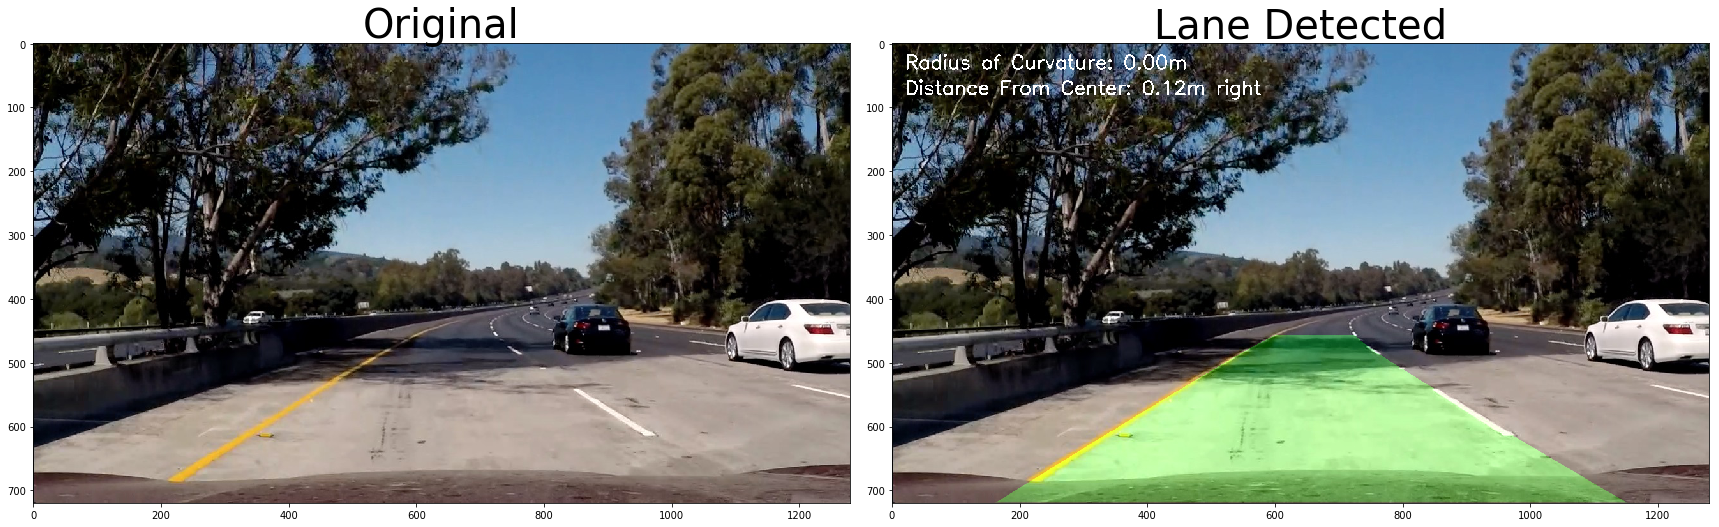

In [125]:
test_image = plt.imread('test_images/test5.jpg')
line=Line()
result = pipeline(test_image)
# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(test_image)
plt.imsave(out_dir+'lane_detected.jpg', result)
ax1.set_title('Original', fontsize=40)

ax2.imshow(result)
ax2.set_title('Lane Detected', fontsize=40)

In [118]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

line=Line()

white_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

(720, 1280)
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

(720, 1280)


  0%|          | 1/1261 [00:00<03:38,  5.76it/s]

(720, 1280)


  0%|          | 2/1261 [00:00<03:47,  5.52it/s]

(720, 1280)


  0%|          | 3/1261 [00:00<03:41,  5.69it/s]

(720, 1280)


  0%|          | 4/1261 [00:00<03:37,  5.79it/s]

(720, 1280)


  0%|          | 5/1261 [00:00<03:34,  5.87it/s]

(720, 1280)


  0%|          | 6/1261 [00:01<03:34,  5.85it/s]

(720, 1280)


  1%|          | 7/1261 [00:01<03:32,  5.90it/s]

(720, 1280)


  1%|          | 9/1261 [00:01<03:24,  6.11it/s]

(720, 1280)
(720, 1280)


  1%|          | 11/1261 [00:02<04:34,  4.55it/s]

(720, 1280)
(720, 1280)


  1%|          | 14/1261 [00:02<03:46,  5.50it/s]

(720, 1280)
(720, 1280)


  1%|          | 15/1261 [00:02<03:41,  5.63it/s]

(720, 1280)
(720, 1280)


  1%|▏         | 18/1261 [00:03<03:26,  6.01it/s]

(720, 1280)
(720, 1280)


  2%|▏         | 19/1261 [00:03<03:24,  6.08it/s]

(720, 1280)
(720, 1280)


  2%|▏         | 21/1261 [00:03<04:03,  5.09it/s]

(720, 1280)


  2%|▏         | 23/1261 [00:04<03:58,  5.18it/s]

(720, 1280)
(720, 1280)


  2%|▏         | 24/1261 [00:04<03:48,  5.42it/s]

(720, 1280)
(720, 1280)


  2%|▏         | 27/1261 [00:04<03:23,  6.06it/s]

(720, 1280)
(720, 1280)


  2%|▏         | 28/1261 [00:04<03:20,  6.14it/s]

(720, 1280)
(720, 1280)


  2%|▏         | 30/1261 [00:05<04:24,  4.65it/s]

(720, 1280)


  2%|▏         | 31/1261 [00:05<04:09,  4.94it/s]

(720, 1280)
(720, 1280)


  3%|▎         | 34/1261 [00:06<03:32,  5.79it/s]

(720, 1280)
(720, 1280)


  3%|▎         | 35/1261 [00:06<03:29,  5.85it/s]

(720, 1280)
(720, 1280)


  3%|▎         | 37/1261 [00:06<03:21,  6.07it/s]

(720, 1280)
(720, 1280)


  3%|▎         | 40/1261 [00:07<03:14,  6.29it/s]

(720, 1280)
(720, 1280)


  3%|▎         | 42/1261 [00:07<03:10,  6.39it/s]

(720, 1280)
(720, 1280)


  3%|▎         | 43/1261 [00:07<03:47,  5.36it/s]

(720, 1280)


  3%|▎         | 44/1261 [00:07<04:02,  5.02it/s]

(720, 1280)


  4%|▎         | 45/1261 [00:08<04:17,  4.73it/s]

(720, 1280)


  4%|▎         | 46/1261 [00:08<04:24,  4.59it/s]

(720, 1280)
(720, 1280)


  4%|▍         | 48/1261 [00:08<04:55,  4.10it/s]

(720, 1280)
(720, 1280)


  4%|▍         | 51/1261 [00:09<03:48,  5.29it/s]

(720, 1280)
(720, 1280)


  4%|▍         | 53/1261 [00:09<03:27,  5.83it/s]

(720, 1280)
(720, 1280)


  4%|▍         | 54/1261 [00:09<03:22,  5.95it/s]

(720, 1280)
(720, 1280)


  4%|▍         | 56/1261 [00:10<03:22,  5.96it/s]

(720, 1280)
(720, 1280)


  5%|▍         | 58/1261 [00:10<03:21,  5.96it/s]

(720, 1280)
(720, 1280)


  5%|▍         | 60/1261 [00:10<03:33,  5.63it/s]

(720, 1280)
(720, 1280)


  5%|▍         | 62/1261 [00:11<03:26,  5.82it/s]

(720, 1280)
(720, 1280)


  5%|▌         | 64/1261 [00:11<03:47,  5.25it/s]

(720, 1280)
(720, 1280)


  5%|▌         | 66/1261 [00:12<04:05,  4.87it/s]

(720, 1280)


  5%|▌         | 67/1261 [00:12<04:16,  4.66it/s]

(720, 1280)


  5%|▌         | 68/1261 [00:12<04:10,  4.75it/s]

(720, 1280)
(720, 1280)


  6%|▌         | 70/1261 [00:12<03:59,  4.96it/s]

(720, 1280)
(720, 1280)


  6%|▌         | 72/1261 [00:13<03:36,  5.50it/s]

(720, 1280)


  6%|▌         | 73/1261 [00:13<03:49,  5.18it/s]

(720, 1280)
(720, 1280)


  6%|▌         | 75/1261 [00:13<04:35,  4.31it/s]

(720, 1280)


  6%|▌         | 76/1261 [00:14<04:19,  4.57it/s]

(720, 1280)
(720, 1280)


  6%|▌         | 78/1261 [00:14<03:47,  5.19it/s]

(720, 1280)
(720, 1280)


  6%|▋         | 81/1261 [00:14<03:17,  5.97it/s]

(720, 1280)
(720, 1280)


  7%|▋         | 83/1261 [00:15<03:07,  6.27it/s]

(720, 1280)
(720, 1280)


  7%|▋         | 84/1261 [00:15<03:08,  6.24it/s]

(720, 1280)
(720, 1280)


  7%|▋         | 86/1261 [00:15<03:12,  6.12it/s]

(720, 1280)
(720, 1280)


  7%|▋         | 89/1261 [00:16<03:05,  6.31it/s]

(720, 1280)
(720, 1280)


  7%|▋         | 90/1261 [00:16<03:16,  5.95it/s]

(720, 1280)


  7%|▋         | 92/1261 [00:16<03:39,  5.32it/s]

(720, 1280)
(720, 1280)


  7%|▋         | 94/1261 [00:17<03:18,  5.87it/s]

(720, 1280)
(720, 1280)


  8%|▊         | 96/1261 [00:17<03:07,  6.23it/s]

(720, 1280)
(720, 1280)


  8%|▊         | 97/1261 [00:17<03:12,  6.05it/s]

(720, 1280)
(720, 1280)


  8%|▊         | 100/1261 [00:18<03:09,  6.11it/s]

(720, 1280)
(720, 1280)


  8%|▊         | 101/1261 [00:18<03:12,  6.03it/s]

(720, 1280)
(720, 1280)


  8%|▊         | 103/1261 [00:18<03:15,  5.91it/s]

(720, 1280)
(720, 1280)


  8%|▊         | 105/1261 [00:18<03:14,  5.95it/s]

(720, 1280)
(720, 1280)


  8%|▊         | 107/1261 [00:19<03:12,  6.00it/s]

(720, 1280)
(720, 1280)


  9%|▊         | 109/1261 [00:19<03:12,  5.98it/s]

(720, 1280)
(720, 1280)


  9%|▉         | 111/1261 [00:19<03:17,  5.82it/s]

(720, 1280)
(720, 1280)


  9%|▉         | 114/1261 [00:20<03:14,  5.91it/s]

(720, 1280)
(720, 1280)


  9%|▉         | 115/1261 [00:20<03:08,  6.07it/s]

(720, 1280)
(720, 1280)


  9%|▉         | 117/1261 [00:20<03:11,  5.98it/s]

(720, 1280)
(720, 1280)


  9%|▉         | 119/1261 [00:21<03:13,  5.90it/s]

(720, 1280)
(720, 1280)


 10%|▉         | 121/1261 [00:21<03:13,  5.88it/s]

(720, 1280)
(720, 1280)


 10%|▉         | 124/1261 [00:22<03:04,  6.15it/s]

(720, 1280)
(720, 1280)


 10%|▉         | 125/1261 [00:22<03:04,  6.14it/s]

(720, 1280)
(720, 1280)


 10%|█         | 127/1261 [00:22<03:41,  5.11it/s]

(720, 1280)


 10%|█         | 128/1261 [00:22<03:56,  4.79it/s]

(720, 1280)


 10%|█         | 129/1261 [00:23<04:02,  4.67it/s]

(720, 1280)


 10%|█         | 130/1261 [00:23<04:18,  4.37it/s]

(720, 1280)


 10%|█         | 131/1261 [00:23<04:21,  4.32it/s]

(720, 1280)


 10%|█         | 132/1261 [00:23<04:20,  4.33it/s]

(720, 1280)


 11%|█         | 133/1261 [00:24<04:25,  4.25it/s]

(720, 1280)


 11%|█         | 134/1261 [00:24<04:26,  4.24it/s]

(720, 1280)


 11%|█         | 135/1261 [00:24<04:21,  4.31it/s]

(720, 1280)


 11%|█         | 136/1261 [00:24<04:20,  4.32it/s]

(720, 1280)


 11%|█         | 137/1261 [00:25<04:23,  4.26it/s]

(720, 1280)


 11%|█         | 138/1261 [00:25<04:19,  4.32it/s]

(720, 1280)


 11%|█         | 139/1261 [00:25<04:11,  4.46it/s]

(720, 1280)
(720, 1280)


 11%|█▏        | 142/1261 [00:26<03:23,  5.49it/s]

(720, 1280)
(720, 1280)


 11%|█▏        | 143/1261 [00:26<03:15,  5.71it/s]

(720, 1280)
(720, 1280)


 12%|█▏        | 146/1261 [00:26<03:01,  6.14it/s]

(720, 1280)
(720, 1280)


 12%|█▏        | 147/1261 [00:26<02:59,  6.22it/s]

(720, 1280)
(720, 1280)


 12%|█▏        | 149/1261 [00:27<03:16,  5.66it/s]

(720, 1280)
(720, 1280)


 12%|█▏        | 151/1261 [00:27<03:15,  5.68it/s]

(720, 1280)
(720, 1280)


 12%|█▏        | 153/1261 [00:27<03:14,  5.70it/s]

(720, 1280)
(720, 1280)


 12%|█▏        | 155/1261 [00:28<03:16,  5.63it/s]

(720, 1280)
(720, 1280)


 12%|█▏        | 157/1261 [00:28<03:17,  5.60it/s]

(720, 1280)
(720, 1280)


 13%|█▎        | 159/1261 [00:28<03:05,  5.93it/s]

(720, 1280)
(720, 1280)


 13%|█▎        | 162/1261 [00:29<02:57,  6.20it/s]

(720, 1280)
(720, 1280)


 13%|█▎        | 163/1261 [00:29<03:04,  5.96it/s]

(720, 1280)
(720, 1280)


 13%|█▎        | 165/1261 [00:29<03:12,  5.70it/s]

(720, 1280)
(720, 1280)


 13%|█▎        | 167/1261 [00:30<03:15,  5.60it/s]

(720, 1280)
(720, 1280)


 13%|█▎        | 169/1261 [00:30<03:17,  5.53it/s]

(720, 1280)
(720, 1280)


 14%|█▎        | 171/1261 [00:31<03:16,  5.55it/s]

(720, 1280)
(720, 1280)


 14%|█▎        | 173/1261 [00:31<03:12,  5.65it/s]

(720, 1280)
(720, 1280)


 14%|█▍        | 175/1261 [00:31<03:11,  5.68it/s]

(720, 1280)
(720, 1280)


 14%|█▍        | 177/1261 [00:32<03:04,  5.88it/s]

(720, 1280)
(720, 1280)


 14%|█▍        | 180/1261 [00:32<02:58,  6.05it/s]

(720, 1280)
(720, 1280)


 14%|█▍        | 181/1261 [00:32<03:01,  5.94it/s]

(720, 1280)
(720, 1280)


 15%|█▍        | 183/1261 [00:33<03:00,  5.96it/s]

(720, 1280)
(720, 1280)


 15%|█▍        | 185/1261 [00:33<02:57,  6.05it/s]

(720, 1280)
(720, 1280)


 15%|█▍        | 187/1261 [00:33<03:05,  5.78it/s]

(720, 1280)
(720, 1280)


 15%|█▍        | 189/1261 [00:34<03:02,  5.88it/s]

(720, 1280)
(720, 1280)


 15%|█▌        | 191/1261 [00:34<03:10,  5.63it/s]

(720, 1280)
(720, 1280)


 15%|█▌        | 194/1261 [00:35<03:01,  5.87it/s]

(720, 1280)
(720, 1280)


 15%|█▌        | 195/1261 [00:35<02:55,  6.09it/s]

(720, 1280)
(720, 1280)


 16%|█▌        | 197/1261 [00:35<02:59,  5.93it/s]

(720, 1280)
(720, 1280)


 16%|█▌        | 199/1261 [00:35<03:01,  5.86it/s]

(720, 1280)
(720, 1280)


 16%|█▌        | 201/1261 [00:36<03:02,  5.80it/s]

(720, 1280)
(720, 1280)


 16%|█▌        | 203/1261 [00:36<03:02,  5.80it/s]

(720, 1280)
(720, 1280)


 16%|█▋        | 205/1261 [00:36<03:00,  5.85it/s]

(720, 1280)
(720, 1280)


 16%|█▋        | 207/1261 [00:37<03:01,  5.79it/s]

(720, 1280)
(720, 1280)


 17%|█▋        | 209/1261 [00:37<02:58,  5.88it/s]

(720, 1280)
(720, 1280)


 17%|█▋        | 211/1261 [00:37<03:01,  5.78it/s]

(720, 1280)
(720, 1280)


 17%|█▋        | 213/1261 [00:38<03:00,  5.81it/s]

(720, 1280)
(720, 1280)


 17%|█▋        | 215/1261 [00:38<03:10,  5.50it/s]

(720, 1280)


 17%|█▋        | 216/1261 [00:38<03:26,  5.07it/s]

(720, 1280)
(720, 1280)


 17%|█▋        | 218/1261 [00:39<03:09,  5.50it/s]

(720, 1280)
(720, 1280)


 18%|█▊        | 221/1261 [00:39<02:52,  6.03it/s]

(720, 1280)
(720, 1280)


 18%|█▊        | 223/1261 [00:39<02:44,  6.29it/s]

(720, 1280)
(720, 1280)


 18%|█▊        | 224/1261 [00:40<02:45,  6.28it/s]

(720, 1280)
(720, 1280)


 18%|█▊        | 227/1261 [00:40<02:47,  6.18it/s]

(720, 1280)
(720, 1280)


 18%|█▊        | 229/1261 [00:40<02:43,  6.33it/s]

(720, 1280)
(720, 1280)


 18%|█▊        | 231/1261 [00:41<02:43,  6.29it/s]

(720, 1280)
(720, 1280)


 18%|█▊        | 232/1261 [00:41<02:50,  6.04it/s]

(720, 1280)
(720, 1280)


 19%|█▊        | 234/1261 [00:41<03:01,  5.65it/s]

(720, 1280)
(720, 1280)

 19%|█▊        | 236/1261 [00:42<03:00,  5.69it/s]


(720, 1280)
(720, 1280)


 19%|█▉        | 238/1261 [00:42<03:07,  5.45it/s]

(720, 1280)


 19%|█▉        | 239/1261 [00:42<03:40,  4.63it/s]

(720, 1280)


 19%|█▉        | 240/1261 [00:43<04:01,  4.23it/s]

(720, 1280)


 19%|█▉        | 241/1261 [00:43<04:08,  4.11it/s]

(720, 1280)
(720, 1280)


 19%|█▉        | 243/1261 [00:43<03:30,  4.84it/s]

(720, 1280)
(720, 1280)


 19%|█▉        | 245/1261 [00:44<03:16,  5.16it/s]

(720, 1280)
(720, 1280)


 20%|█▉        | 247/1261 [00:44<03:00,  5.61it/s]

(720, 1280)
(720, 1280)


 20%|█▉        | 249/1261 [00:44<03:00,  5.60it/s]

(720, 1280)
(720, 1280)


 20%|█▉        | 252/1261 [00:45<02:45,  6.10it/s]

(720, 1280)
(720, 1280)


 20%|██        | 253/1261 [00:45<02:43,  6.17it/s]

(720, 1280)
(720, 1280)


 20%|██        | 255/1261 [00:45<02:52,  5.84it/s]

(720, 1280)
(720, 1280)


 20%|██        | 257/1261 [00:46<03:02,  5.49it/s]

(720, 1280)


 20%|██        | 258/1261 [00:46<03:11,  5.23it/s]

(720, 1280)
(720, 1280)


 21%|██        | 260/1261 [00:46<03:08,  5.32it/s]

(720, 1280)
(720, 1280)


 21%|██        | 262/1261 [00:47<02:55,  5.68it/s]

(720, 1280)
(720, 1280)


 21%|██        | 265/1261 [00:47<02:43,  6.09it/s]

(720, 1280)
(720, 1280)


 21%|██        | 267/1261 [00:47<02:36,  6.33it/s]

(720, 1280)
(720, 1280)


 21%|██▏       | 269/1261 [00:48<02:33,  6.48it/s]

(720, 1280)
(720, 1280)


 21%|██▏       | 271/1261 [00:48<02:34,  6.42it/s]

(720, 1280)
(720, 1280)


 22%|██▏       | 273/1261 [00:48<02:32,  6.49it/s]

(720, 1280)
(720, 1280)


 22%|██▏       | 275/1261 [00:49<02:30,  6.53it/s]

(720, 1280)
(720, 1280)


 22%|██▏       | 277/1261 [00:49<02:28,  6.63it/s]

(720, 1280)
(720, 1280)


 22%|██▏       | 279/1261 [00:49<02:27,  6.67it/s]

(720, 1280)
(720, 1280)


 22%|██▏       | 281/1261 [00:49<02:28,  6.59it/s]

(720, 1280)
(720, 1280)


 22%|██▏       | 283/1261 [00:50<02:30,  6.51it/s]

(720, 1280)
(720, 1280)


 23%|██▎       | 285/1261 [00:50<02:30,  6.50it/s]

(720, 1280)
(720, 1280)


 23%|██▎       | 287/1261 [00:50<02:28,  6.57it/s]

(720, 1280)
(720, 1280)


 23%|██▎       | 289/1261 [00:51<02:28,  6.54it/s]

(720, 1280)
(720, 1280)


 23%|██▎       | 291/1261 [00:51<02:29,  6.50it/s]

(720, 1280)
(720, 1280)


 23%|██▎       | 292/1261 [00:51<02:32,  6.34it/s]

(720, 1280)
(720, 1280)


 23%|██▎       | 294/1261 [00:52<02:42,  5.94it/s]

(720, 1280)
(720, 1280)


 23%|██▎       | 296/1261 [00:52<02:45,  5.85it/s]

(720, 1280)
(720, 1280)


 24%|██▎       | 298/1261 [00:52<02:40,  6.01it/s]

(720, 1280)
(720, 1280)


 24%|██▍       | 300/1261 [00:53<03:03,  5.24it/s]

(720, 1280)


 24%|██▍       | 301/1261 [00:53<03:19,  4.81it/s]

(720, 1280)
(720, 1280)


 24%|██▍       | 303/1261 [00:53<03:07,  5.12it/s]

(720, 1280)
(720, 1280)


 24%|██▍       | 305/1261 [00:54<03:03,  5.21it/s]

(720, 1280)
(720, 1280)


 24%|██▍       | 308/1261 [00:54<02:41,  5.91it/s]

(720, 1280)
(720, 1280)


 25%|██▍       | 310/1261 [00:54<02:34,  6.14it/s]

(720, 1280)
(720, 1280)


 25%|██▍       | 312/1261 [00:55<02:30,  6.32it/s]

(720, 1280)
(720, 1280)


 25%|██▍       | 314/1261 [00:55<02:28,  6.37it/s]

(720, 1280)
(720, 1280)


 25%|██▌       | 316/1261 [00:55<02:24,  6.55it/s]

(720, 1280)
(720, 1280)


 25%|██▌       | 318/1261 [00:56<02:22,  6.61it/s]

(720, 1280)
(720, 1280)


 25%|██▌       | 320/1261 [00:56<02:22,  6.58it/s]

(720, 1280)
(720, 1280)


 26%|██▌       | 322/1261 [00:56<02:21,  6.64it/s]

(720, 1280)
(720, 1280)


 26%|██▌       | 324/1261 [00:57<02:22,  6.56it/s]

(720, 1280)
(720, 1280)


 26%|██▌       | 326/1261 [00:57<02:20,  6.63it/s]

(720, 1280)
(720, 1280)


 26%|██▌       | 327/1261 [00:57<02:22,  6.57it/s]

(720, 1280)
(720, 1280)


 26%|██▌       | 329/1261 [00:57<02:48,  5.52it/s]

(720, 1280)


 26%|██▌       | 330/1261 [00:58<03:01,  5.13it/s]

(720, 1280)
(720, 1280)


 26%|██▋       | 333/1261 [00:58<02:40,  5.78it/s]

(720, 1280)
(720, 1280)


 27%|██▋       | 335/1261 [00:58<02:30,  6.17it/s]

(720, 1280)
(720, 1280)


 27%|██▋       | 337/1261 [00:59<02:26,  6.30it/s]

(720, 1280)
(720, 1280)


 27%|██▋       | 339/1261 [00:59<02:23,  6.43it/s]

(720, 1280)
(720, 1280)


 27%|██▋       | 341/1261 [00:59<02:20,  6.56it/s]

(720, 1280)
(720, 1280)


 27%|██▋       | 343/1261 [01:00<02:18,  6.62it/s]

(720, 1280)
(720, 1280)


 27%|██▋       | 345/1261 [01:00<02:18,  6.61it/s]

(720, 1280)
(720, 1280)


 28%|██▊       | 347/1261 [01:00<02:17,  6.65it/s]

(720, 1280)
(720, 1280)


 28%|██▊       | 349/1261 [01:01<02:17,  6.61it/s]

(720, 1280)
(720, 1280)


 28%|██▊       | 351/1261 [01:01<02:17,  6.62it/s]

(720, 1280)
(720, 1280)


 28%|██▊       | 352/1261 [01:01<02:20,  6.49it/s]

(720, 1280)
(720, 1280)


 28%|██▊       | 354/1261 [01:02<02:55,  5.15it/s]

(720, 1280)


 28%|██▊       | 356/1261 [01:02<02:43,  5.55it/s]

(720, 1280)
(720, 1280)
(720, 1280)


 28%|██▊       | 359/1261 [01:02<02:28,  6.08it/s]

(720, 1280)
(720, 1280)


 29%|██▊       | 361/1261 [01:03<02:22,  6.32it/s]

(720, 1280)
(720, 1280)


 29%|██▉       | 363/1261 [01:03<02:18,  6.49it/s]

(720, 1280)
(720, 1280)


 29%|██▉       | 364/1261 [01:03<02:24,  6.19it/s]

(720, 1280)
(720, 1280)


 29%|██▉       | 366/1261 [01:03<02:25,  6.17it/s]

(720, 1280)
(720, 1280)


 29%|██▉       | 368/1261 [01:04<02:42,  5.50it/s]

(720, 1280)


 29%|██▉       | 369/1261 [01:04<02:56,  5.06it/s]

(720, 1280)


 29%|██▉       | 371/1261 [01:04<02:46,  5.35it/s]

(720, 1280)
(720, 1280)


 30%|██▉       | 373/1261 [01:05<02:32,  5.83it/s]

(720, 1280)
(720, 1280)


 30%|██▉       | 374/1261 [01:05<02:31,  5.85it/s]

(720, 1280)
(720, 1280)


 30%|██▉       | 376/1261 [01:05<02:32,  5.82it/s]

(720, 1280)


 30%|██▉       | 377/1261 [01:05<02:43,  5.40it/s]

(720, 1280)


 30%|██▉       | 378/1261 [01:06<02:49,  5.20it/s]

(720, 1280)
(720, 1280)


 30%|███       | 380/1261 [01:06<02:37,  5.58it/s]

(720, 1280)
(720, 1280)


 30%|███       | 383/1261 [01:06<02:23,  6.13it/s]

(720, 1280)
(720, 1280)


 31%|███       | 385/1261 [01:07<02:17,  6.39it/s]

(720, 1280)
(720, 1280)


 31%|███       | 387/1261 [01:07<02:15,  6.44it/s]

(720, 1280)
(720, 1280)


 31%|███       | 389/1261 [01:07<02:12,  6.59it/s]

(720, 1280)
(720, 1280)


 31%|███       | 391/1261 [01:08<02:12,  6.58it/s]

(720, 1280)
(720, 1280)


 31%|███       | 393/1261 [01:08<02:13,  6.52it/s]

(720, 1280)
(720, 1280)


 31%|███▏      | 395/1261 [01:08<02:11,  6.59it/s]

(720, 1280)
(720, 1280)


 31%|███▏      | 397/1261 [01:09<02:11,  6.59it/s]

(720, 1280)
(720, 1280)


 32%|███▏      | 399/1261 [01:09<02:08,  6.69it/s]

(720, 1280)
(720, 1280)


 32%|███▏      | 401/1261 [01:09<02:09,  6.64it/s]

(720, 1280)
(720, 1280)


 32%|███▏      | 403/1261 [01:09<02:11,  6.53it/s]

(720, 1280)
(720, 1280)


 32%|███▏      | 405/1261 [01:10<02:11,  6.51it/s]

(720, 1280)
(720, 1280)


 32%|███▏      | 407/1261 [01:10<02:10,  6.55it/s]

(720, 1280)
(720, 1280)


 32%|███▏      | 409/1261 [01:10<02:08,  6.62it/s]

(720, 1280)
(720, 1280)


 33%|███▎      | 411/1261 [01:11<02:07,  6.65it/s]

(720, 1280)
(720, 1280)


 33%|███▎      | 412/1261 [01:11<02:08,  6.60it/s]

(720, 1280)
(720, 1280)


 33%|███▎      | 415/1261 [01:11<02:07,  6.62it/s]

(720, 1280)
(720, 1280)


 33%|███▎      | 417/1261 [01:12<02:07,  6.63it/s]

(720, 1280)
(720, 1280)


 33%|███▎      | 419/1261 [01:12<02:06,  6.67it/s]

(720, 1280)
(720, 1280)


 33%|███▎      | 421/1261 [01:12<02:07,  6.60it/s]

(720, 1280)
(720, 1280)


 34%|███▎      | 423/1261 [01:13<02:08,  6.54it/s]

(720, 1280)
(720, 1280)


 34%|███▎      | 425/1261 [01:13<02:06,  6.63it/s]

(720, 1280)
(720, 1280)


 34%|███▍      | 427/1261 [01:13<02:06,  6.61it/s]

(720, 1280)
(720, 1280)


 34%|███▍      | 429/1261 [01:13<02:05,  6.65it/s]

(720, 1280)
(720, 1280)


 34%|███▍      | 431/1261 [01:14<02:05,  6.63it/s]

(720, 1280)
(720, 1280)


 34%|███▍      | 432/1261 [01:14<02:13,  6.22it/s]

(720, 1280)
(720, 1280)


 34%|███▍      | 434/1261 [01:14<02:21,  5.84it/s]

(720, 1280)
(720, 1280)


 35%|███▍      | 437/1261 [01:15<02:15,  6.07it/s]

(720, 1280)
(720, 1280)


 35%|███▍      | 439/1261 [01:15<02:13,  6.14it/s]

(720, 1280)
(720, 1280)


 35%|███▍      | 441/1261 [01:15<02:10,  6.27it/s]

(720, 1280)
(720, 1280)


 35%|███▌      | 443/1261 [01:16<02:08,  6.38it/s]

(720, 1280)
(720, 1280)


 35%|███▌      | 445/1261 [01:16<02:06,  6.47it/s]

(720, 1280)
(720, 1280)


 35%|███▌      | 446/1261 [01:16<02:06,  6.43it/s]

(720, 1280)
(720, 1280)


 36%|███▌      | 449/1261 [01:17<02:08,  6.33it/s]

(720, 1280)
(720, 1280)


 36%|███▌      | 450/1261 [01:17<02:10,  6.23it/s]

(720, 1280)
(720, 1280)


 36%|███▌      | 452/1261 [01:17<02:15,  5.95it/s]

(720, 1280)
(720, 1280)


 36%|███▌      | 454/1261 [01:18<02:18,  5.83it/s]

(720, 1280)
(720, 1280)


 36%|███▌      | 456/1261 [01:18<02:23,  5.59it/s]

(720, 1280)
(720, 1280)


 36%|███▋      | 458/1261 [01:18<02:24,  5.56it/s]

(720, 1280)
(720, 1280)


 37%|███▋      | 461/1261 [01:19<02:16,  5.88it/s]

(720, 1280)
(720, 1280)


 37%|███▋      | 463/1261 [01:19<02:11,  6.06it/s]

(720, 1280)
(720, 1280)


 37%|███▋      | 465/1261 [01:19<02:06,  6.32it/s]

(720, 1280)
(720, 1280)


 37%|███▋      | 467/1261 [01:20<02:02,  6.46it/s]

(720, 1280)
(720, 1280)


 37%|███▋      | 469/1261 [01:20<02:03,  6.42it/s]

(720, 1280)
(720, 1280)


 37%|███▋      | 471/1261 [01:20<02:01,  6.51it/s]

(720, 1280)
(720, 1280)


 38%|███▊      | 473/1261 [01:21<02:00,  6.56it/s]

(720, 1280)
(720, 1280)


 38%|███▊      | 474/1261 [01:21<01:59,  6.59it/s]

(720, 1280)
(720, 1280)


 38%|███▊      | 476/1261 [01:21<02:09,  6.07it/s]

(720, 1280)
(720, 1280)


 38%|███▊      | 478/1261 [01:22<02:15,  5.80it/s]

(720, 1280)
(720, 1280)


 38%|███▊      | 480/1261 [01:22<02:08,  6.08it/s]

(720, 1280)
(720, 1280)


 38%|███▊      | 482/1261 [01:22<02:07,  6.11it/s]

(720, 1280)
(720, 1280)


 38%|███▊      | 484/1261 [01:23<02:25,  5.34it/s]

(720, 1280)


 38%|███▊      | 485/1261 [01:23<02:36,  4.96it/s]

(720, 1280)
(720, 1280)


 39%|███▊      | 488/1261 [01:23<02:14,  5.73it/s]

(720, 1280)
(720, 1280)


 39%|███▉      | 490/1261 [01:24<02:06,  6.10it/s]

(720, 1280)
(720, 1280)


 39%|███▉      | 491/1261 [01:24<02:04,  6.19it/s]

(720, 1280)
(720, 1280)


 39%|███▉      | 493/1261 [01:24<02:06,  6.08it/s]

(720, 1280)
(720, 1280)


 39%|███▉      | 495/1261 [01:24<02:12,  5.78it/s]

(720, 1280)
(720, 1280)


 39%|███▉      | 498/1261 [01:25<02:08,  5.93it/s]

(720, 1280)
(720, 1280)


 40%|███▉      | 499/1261 [01:25<02:08,  5.91it/s]

(720, 1280)
(720, 1280)


 40%|███▉      | 501/1261 [01:25<02:04,  6.10it/s]

(720, 1280)
(720, 1280)


 40%|███▉      | 504/1261 [01:26<02:00,  6.30it/s]

(720, 1280)
(720, 1280)


 40%|████      | 506/1261 [01:26<01:58,  6.40it/s]

(720, 1280)
(720, 1280)


 40%|████      | 508/1261 [01:27<01:57,  6.42it/s]

(720, 1280)
(720, 1280)


 40%|████      | 509/1261 [01:27<01:57,  6.40it/s]

(720, 1280)
(720, 1280)


 41%|████      | 511/1261 [01:27<02:11,  5.69it/s]

(720, 1280)


 41%|████      | 512/1261 [01:27<02:21,  5.28it/s]

(720, 1280)


 41%|████      | 513/1261 [01:28<02:28,  5.03it/s]

(720, 1280)
(720, 1280)


 41%|████      | 515/1261 [01:28<02:13,  5.60it/s]

(720, 1280)
(720, 1280)


 41%|████      | 518/1261 [01:28<02:01,  6.11it/s]

(720, 1280)
(720, 1280)


 41%|████      | 519/1261 [01:28<01:59,  6.20it/s]

(720, 1280)
(720, 1280)


 41%|████▏     | 521/1261 [01:29<02:00,  6.16it/s]

(720, 1280)
(720, 1280)


 42%|████▏     | 524/1261 [01:29<01:57,  6.28it/s]

(720, 1280)
(720, 1280)


 42%|████▏     | 526/1261 [01:30<01:54,  6.42it/s]

(720, 1280)
(720, 1280)


 42%|████▏     | 528/1261 [01:30<01:52,  6.49it/s]

(720, 1280)
(720, 1280)


 42%|████▏     | 530/1261 [01:30<01:52,  6.52it/s]

(720, 1280)
(720, 1280)


 42%|████▏     | 532/1261 [01:30<01:50,  6.57it/s]

(720, 1280)
(720, 1280)


 42%|████▏     | 534/1261 [01:31<01:50,  6.58it/s]

(720, 1280)
(720, 1280)


 43%|████▎     | 536/1261 [01:31<01:53,  6.41it/s]

(720, 1280)
(720, 1280)


 43%|████▎     | 538/1261 [01:31<01:52,  6.42it/s]

(720, 1280)
(720, 1280)


 43%|████▎     | 540/1261 [01:32<01:52,  6.43it/s]

(720, 1280)
(720, 1280)


 43%|████▎     | 542/1261 [01:32<01:52,  6.42it/s]

(720, 1280)
(720, 1280)


 43%|████▎     | 544/1261 [01:32<01:50,  6.48it/s]

(720, 1280)
(720, 1280)


 43%|████▎     | 546/1261 [01:33<01:49,  6.51it/s]

(720, 1280)
(720, 1280)


 43%|████▎     | 548/1261 [01:33<01:47,  6.61it/s]

(720, 1280)
(720, 1280)


 44%|████▎     | 550/1261 [01:33<01:52,  6.31it/s]

(720, 1280)
(720, 1280)


 44%|████▍     | 552/1261 [01:34<01:49,  6.45it/s]

(720, 1280)
(720, 1280)


 44%|████▍     | 554/1261 [01:34<01:49,  6.43it/s]

(720, 1280)
(720, 1280)


 44%|████▍     | 556/1261 [01:34<01:49,  6.45it/s]

(720, 1280)
(720, 1280)


 44%|████▍     | 557/1261 [01:34<01:53,  6.22it/s]

(720, 1280)
(720, 1280)


 44%|████▍     | 559/1261 [01:35<01:57,  5.97it/s]

(720, 1280)
(720, 1280)


 45%|████▍     | 562/1261 [01:35<01:55,  6.04it/s]

(720, 1280)
(720, 1280)


 45%|████▍     | 563/1261 [01:35<01:52,  6.20it/s]

(720, 1280)
(720, 1280)


 45%|████▍     | 566/1261 [01:36<01:47,  6.44it/s]

(720, 1280)
(720, 1280)


 45%|████▌     | 568/1261 [01:36<01:45,  6.55it/s]

(720, 1280)
(720, 1280)


 45%|████▌     | 570/1261 [01:36<01:43,  6.67it/s]

(720, 1280)
(720, 1280)


 45%|████▌     | 572/1261 [01:37<01:42,  6.74it/s]

(720, 1280)
(720, 1280)


 46%|████▌     | 574/1261 [01:37<01:42,  6.68it/s]

(720, 1280)
(720, 1280)


 46%|████▌     | 576/1261 [01:37<01:41,  6.74it/s]

(720, 1280)
(720, 1280)


 46%|████▌     | 578/1261 [01:38<01:40,  6.78it/s]

(720, 1280)
(720, 1280)


 46%|████▌     | 579/1261 [01:38<01:48,  6.26it/s]

(720, 1280)


 46%|████▌     | 580/1261 [01:38<01:59,  5.68it/s]

(720, 1280)


 46%|████▌     | 581/1261 [01:38<02:12,  5.12it/s]

(720, 1280)
(720, 1280)


 46%|████▋     | 584/1261 [01:39<01:53,  5.96it/s]

(720, 1280)
(720, 1280)


 46%|████▋     | 586/1261 [01:39<01:48,  6.25it/s]

(720, 1280)
(720, 1280)


 47%|████▋     | 588/1261 [01:39<01:44,  6.42it/s]

(720, 1280)
(720, 1280)


 47%|████▋     | 590/1261 [01:40<01:42,  6.53it/s]

(720, 1280)
(720, 1280)


 47%|████▋     | 592/1261 [01:40<01:40,  6.66it/s]

(720, 1280)
(720, 1280)


 47%|████▋     | 594/1261 [01:40<01:38,  6.76it/s]

(720, 1280)
(720, 1280)


 47%|████▋     | 596/1261 [01:41<01:41,  6.56it/s]

(720, 1280)
(720, 1280)


 47%|████▋     | 598/1261 [01:41<01:44,  6.32it/s]

(720, 1280)
(720, 1280)


 48%|████▊     | 599/1261 [01:41<01:46,  6.20it/s]

(720, 1280)
(720, 1280)


 48%|████▊     | 602/1261 [01:42<01:44,  6.32it/s]

(720, 1280)
(720, 1280)


 48%|████▊     | 604/1261 [01:42<01:43,  6.35it/s]

(720, 1280)
(720, 1280)


 48%|████▊     | 605/1261 [01:42<01:43,  6.34it/s]

(720, 1280)
(720, 1280)


 48%|████▊     | 607/1261 [01:42<01:44,  6.29it/s]

(720, 1280)
(720, 1280)


 48%|████▊     | 609/1261 [01:43<01:44,  6.22it/s]

(720, 1280)
(720, 1280)


 48%|████▊     | 611/1261 [01:43<01:46,  6.09it/s]

(720, 1280)
(720, 1280)


 49%|████▊     | 613/1261 [01:43<01:46,  6.11it/s]

(720, 1280)
(720, 1280)


 49%|████▉     | 615/1261 [01:44<01:45,  6.13it/s]

(720, 1280)
(720, 1280)


 49%|████▉     | 618/1261 [01:44<01:43,  6.22it/s]

(720, 1280)
(720, 1280)


 49%|████▉     | 620/1261 [01:44<01:39,  6.41it/s]

(720, 1280)
(720, 1280)


 49%|████▉     | 622/1261 [01:45<01:39,  6.45it/s]

(720, 1280)
(720, 1280)


 49%|████▉     | 624/1261 [01:45<01:39,  6.42it/s]

(720, 1280)
(720, 1280)


 50%|████▉     | 626/1261 [01:45<01:37,  6.53it/s]

(720, 1280)
(720, 1280)


 50%|████▉     | 627/1261 [01:46<01:39,  6.39it/s]

(720, 1280)
(720, 1280)


 50%|████▉     | 629/1261 [01:46<01:44,  6.05it/s]

(720, 1280)
(720, 1280)


 50%|█████     | 631/1261 [01:46<01:43,  6.07it/s]

(720, 1280)
(720, 1280)


 50%|█████     | 633/1261 [01:47<01:45,  5.95it/s]

(720, 1280)
(720, 1280)


 50%|█████     | 635/1261 [01:47<02:01,  5.15it/s]

(720, 1280)


 50%|█████     | 636/1261 [01:47<02:13,  4.70it/s]

(720, 1280)


 51%|█████     | 637/1261 [01:47<02:16,  4.57it/s]

(720, 1280)


 51%|█████     | 638/1261 [01:48<02:10,  4.78it/s]

(720, 1280)
(720, 1280)


 51%|█████     | 640/1261 [01:48<01:57,  5.30it/s]

(720, 1280)
(720, 1280)


 51%|█████     | 643/1261 [01:48<01:45,  5.86it/s]

(720, 1280)
(720, 1280)


 51%|█████     | 645/1261 [01:49<01:40,  6.11it/s]

(720, 1280)
(720, 1280)


 51%|█████▏    | 647/1261 [01:49<01:37,  6.30it/s]

(720, 1280)
(720, 1280)


 51%|█████▏    | 649/1261 [01:49<01:34,  6.45it/s]

(720, 1280)
(720, 1280)


 52%|█████▏    | 651/1261 [01:50<01:33,  6.49it/s]

(720, 1280)
(720, 1280)


 52%|█████▏    | 653/1261 [01:50<01:34,  6.42it/s]

(720, 1280)
(720, 1280)


 52%|█████▏    | 654/1261 [01:50<01:34,  6.45it/s]

(720, 1280)
(720, 1280)


 52%|█████▏    | 656/1261 [01:50<01:36,  6.28it/s]

(720, 1280)
(720, 1280)


 52%|█████▏    | 658/1261 [01:51<01:38,  6.11it/s]

(720, 1280)
(720, 1280)


 52%|█████▏    | 660/1261 [01:51<01:39,  6.05it/s]

(720, 1280)
(720, 1280)


 52%|█████▏    | 662/1261 [01:51<01:38,  6.11it/s]

(720, 1280)
(720, 1280)


 53%|█████▎    | 664/1261 [01:52<01:35,  6.23it/s]

(720, 1280)
(720, 1280)


 53%|█████▎    | 666/1261 [01:52<01:36,  6.18it/s]

(720, 1280)
(720, 1280)


 53%|█████▎    | 668/1261 [01:52<01:35,  6.24it/s]

(720, 1280)
(720, 1280)


 53%|█████▎    | 671/1261 [01:53<01:33,  6.32it/s]

(720, 1280)
(720, 1280)


 53%|█████▎    | 672/1261 [01:53<01:33,  6.33it/s]

(720, 1280)
(720, 1280)


 53%|█████▎    | 674/1261 [01:53<01:37,  5.99it/s]

(720, 1280)
(720, 1280)


 54%|█████▎    | 677/1261 [01:54<01:37,  5.99it/s]

(720, 1280)
(720, 1280)


 54%|█████▍    | 679/1261 [01:54<01:34,  6.16it/s]

(720, 1280)
(720, 1280)


 54%|█████▍    | 681/1261 [01:55<01:31,  6.32it/s]

(720, 1280)
(720, 1280)


 54%|█████▍    | 683/1261 [01:55<01:31,  6.34it/s]

(720, 1280)
(720, 1280)


 54%|█████▍    | 684/1261 [01:55<01:30,  6.35it/s]

(720, 1280)
(720, 1280)


 54%|█████▍    | 686/1261 [01:55<01:30,  6.33it/s]

(720, 1280)
(720, 1280)


 55%|█████▍    | 689/1261 [01:56<01:29,  6.40it/s]

(720, 1280)
(720, 1280)


 55%|█████▍    | 691/1261 [01:56<01:29,  6.36it/s]

(720, 1280)
(720, 1280)


 55%|█████▍    | 693/1261 [01:56<01:28,  6.44it/s]

(720, 1280)
(720, 1280)


 55%|█████▌    | 694/1261 [01:57<01:29,  6.34it/s]

(720, 1280)
(720, 1280)


 55%|█████▌    | 696/1261 [01:57<01:33,  6.07it/s]

(720, 1280)
(720, 1280)


 55%|█████▌    | 699/1261 [01:57<01:28,  6.33it/s]

(720, 1280)
(720, 1280)


 56%|█████▌    | 701/1261 [01:58<01:28,  6.34it/s]

(720, 1280)
(720, 1280)


 56%|█████▌    | 702/1261 [01:58<01:27,  6.36it/s]

(720, 1280)
(720, 1280)


 56%|█████▌    | 704/1261 [01:58<01:47,  5.19it/s]

(720, 1280)
(720, 1280)


 56%|█████▌    | 706/1261 [01:59<01:40,  5.53it/s]

(720, 1280)
(720, 1280)


 56%|█████▌    | 708/1261 [01:59<01:50,  4.99it/s]

(720, 1280)


 56%|█████▋    | 710/1261 [01:59<01:44,  5.29it/s]

(720, 1280)
(720, 1280)


 56%|█████▋    | 711/1261 [02:00<01:40,  5.49it/s]

(720, 1280)
(720, 1280)


 57%|█████▋    | 713/1261 [02:00<01:34,  5.78it/s]

(720, 1280)
(720, 1280)


 57%|█████▋    | 715/1261 [02:00<01:34,  5.79it/s]

(720, 1280)
(720, 1280)


 57%|█████▋    | 717/1261 [02:01<01:33,  5.80it/s]

(720, 1280)
(720, 1280)


 57%|█████▋    | 719/1261 [02:01<01:41,  5.36it/s]

(720, 1280)


 57%|█████▋    | 720/1261 [02:01<01:50,  4.89it/s]

(720, 1280)


 57%|█████▋    | 721/1261 [02:02<01:53,  4.77it/s]

(720, 1280)


 57%|█████▋    | 722/1261 [02:02<01:53,  4.73it/s]

(720, 1280)


 57%|█████▋    | 723/1261 [02:02<01:54,  4.70it/s]

(720, 1280)


 57%|█████▋    | 724/1261 [02:02<01:51,  4.80it/s]

(720, 1280)
(720, 1280)


 58%|█████▊    | 726/1261 [02:02<01:40,  5.31it/s]

(720, 1280)
(720, 1280)


 58%|█████▊    | 728/1261 [02:03<01:31,  5.84it/s]

(720, 1280)
(720, 1280)


 58%|█████▊    | 730/1261 [02:03<01:29,  5.90it/s]

(720, 1280)
(720, 1280)


 58%|█████▊    | 733/1261 [02:04<01:24,  6.25it/s]

(720, 1280)
(720, 1280)


 58%|█████▊    | 734/1261 [02:04<01:23,  6.33it/s]

(720, 1280)
(720, 1280)


 58%|█████▊    | 737/1261 [02:04<01:23,  6.29it/s]

(720, 1280)
(720, 1280)


 59%|█████▊    | 738/1261 [02:04<01:22,  6.33it/s]

(720, 1280)
(720, 1280)


 59%|█████▉    | 741/1261 [02:05<01:19,  6.51it/s]

(720, 1280)
(720, 1280)


 59%|█████▉    | 742/1261 [02:05<01:20,  6.42it/s]

(720, 1280)
(720, 1280)


 59%|█████▉    | 744/1261 [02:05<01:22,  6.28it/s]

(720, 1280)
(720, 1280)


 59%|█████▉    | 746/1261 [02:06<01:32,  5.59it/s]

(720, 1280)
(720, 1280)


 59%|█████▉    | 748/1261 [02:06<01:30,  5.68it/s]

(720, 1280)
(720, 1280)


 60%|█████▉    | 751/1261 [02:07<01:24,  6.07it/s]

(720, 1280)
(720, 1280)


 60%|█████▉    | 753/1261 [02:07<01:21,  6.26it/s]

(720, 1280)
(720, 1280)


 60%|█████▉    | 755/1261 [02:07<01:19,  6.33it/s]

(720, 1280)
(720, 1280)


 60%|██████    | 757/1261 [02:08<01:19,  6.31it/s]

(720, 1280)
(720, 1280)


 60%|██████    | 759/1261 [02:08<01:17,  6.50it/s]

(720, 1280)
(720, 1280)


 60%|██████    | 761/1261 [02:08<01:17,  6.42it/s]

(720, 1280)
(720, 1280)


 61%|██████    | 763/1261 [02:08<01:17,  6.44it/s]

(720, 1280)
(720, 1280)


 61%|██████    | 765/1261 [02:09<01:16,  6.47it/s]

(720, 1280)
(720, 1280)


 61%|██████    | 766/1261 [02:09<01:17,  6.42it/s]

(720, 1280)
(720, 1280)


 61%|██████    | 768/1261 [02:09<01:17,  6.40it/s]

(720, 1280)
(720, 1280)


 61%|██████    | 771/1261 [02:10<01:18,  6.26it/s]

(720, 1280)
(720, 1280)


 61%|██████    | 772/1261 [02:10<01:18,  6.22it/s]

(720, 1280)
(720, 1280)


 61%|██████▏   | 775/1261 [02:10<01:16,  6.37it/s]

(720, 1280)
(720, 1280)


 62%|██████▏   | 777/1261 [02:11<01:14,  6.46it/s]

(720, 1280)
(720, 1280)


 62%|██████▏   | 778/1261 [02:11<01:13,  6.54it/s]

(720, 1280)
(720, 1280)


 62%|██████▏   | 781/1261 [02:11<01:14,  6.42it/s]

(720, 1280)
(720, 1280)


 62%|██████▏   | 783/1261 [02:12<01:14,  6.45it/s]

(720, 1280)
(720, 1280)


 62%|██████▏   | 785/1261 [02:12<01:13,  6.49it/s]

(720, 1280)
(720, 1280)


 62%|██████▏   | 787/1261 [02:12<01:12,  6.51it/s]

(720, 1280)
(720, 1280)


 63%|██████▎   | 789/1261 [02:12<01:12,  6.49it/s]

(720, 1280)
(720, 1280)


 63%|██████▎   | 791/1261 [02:13<01:11,  6.61it/s]

(720, 1280)
(720, 1280)


 63%|██████▎   | 793/1261 [02:13<01:11,  6.52it/s]

(720, 1280)
(720, 1280)


 63%|██████▎   | 795/1261 [02:13<01:11,  6.51it/s]

(720, 1280)
(720, 1280)


 63%|██████▎   | 797/1261 [02:14<01:11,  6.46it/s]

(720, 1280)
(720, 1280)


 63%|██████▎   | 799/1261 [02:14<01:11,  6.49it/s]

(720, 1280)
(720, 1280)


 64%|██████▎   | 801/1261 [02:14<01:09,  6.61it/s]

(720, 1280)
(720, 1280)


 64%|██████▎   | 803/1261 [02:15<01:10,  6.52it/s]

(720, 1280)
(720, 1280)


 64%|██████▍   | 805/1261 [02:15<01:10,  6.44it/s]

(720, 1280)
(720, 1280)


 64%|██████▍   | 807/1261 [02:15<01:10,  6.48it/s]

(720, 1280)
(720, 1280)


 64%|██████▍   | 809/1261 [02:16<01:10,  6.45it/s]

(720, 1280)
(720, 1280)


 64%|██████▍   | 811/1261 [02:16<01:09,  6.50it/s]

(720, 1280)
(720, 1280)


 64%|██████▍   | 813/1261 [02:16<01:09,  6.46it/s]

(720, 1280)
(720, 1280)


 65%|██████▍   | 815/1261 [02:16<01:08,  6.47it/s]

(720, 1280)
(720, 1280)


 65%|██████▍   | 817/1261 [02:17<01:08,  6.50it/s]

(720, 1280)
(720, 1280)


 65%|██████▍   | 819/1261 [02:17<01:09,  6.35it/s]

(720, 1280)
(720, 1280)


 65%|██████▌   | 820/1261 [02:17<01:13,  6.03it/s]

(720, 1280)
(720, 1280)


 65%|██████▌   | 822/1261 [02:18<01:20,  5.46it/s]

(720, 1280)
(720, 1280)


 65%|██████▌   | 825/1261 [02:18<01:13,  5.90it/s]

(720, 1280)
(720, 1280)


 66%|██████▌   | 826/1261 [02:18<01:12,  6.03it/s]

(720, 1280)
(720, 1280)


 66%|██████▌   | 828/1261 [02:19<01:12,  6.00it/s]

(720, 1280)
(720, 1280)


 66%|██████▌   | 830/1261 [02:19<01:11,  6.04it/s]

(720, 1280)
(720, 1280)


 66%|██████▌   | 832/1261 [02:19<01:10,  6.05it/s]

(720, 1280)
(720, 1280)


 66%|██████▌   | 835/1261 [02:20<01:08,  6.21it/s]

(720, 1280)
(720, 1280)


 66%|██████▋   | 837/1261 [02:20<01:07,  6.24it/s]

(720, 1280)
(720, 1280)


 67%|██████▋   | 839/1261 [02:20<01:06,  6.36it/s]

(720, 1280)
(720, 1280)


 67%|██████▋   | 841/1261 [02:21<01:04,  6.47it/s]

(720, 1280)
(720, 1280)


 67%|██████▋   | 842/1261 [02:21<01:05,  6.37it/s]

(720, 1280)
(720, 1280)


 67%|██████▋   | 844/1261 [02:21<01:17,  5.41it/s]

(720, 1280)
(720, 1280)


 67%|██████▋   | 847/1261 [02:22<01:08,  6.07it/s]

(720, 1280)
(720, 1280)


 67%|██████▋   | 848/1261 [02:22<01:10,  5.88it/s]

(720, 1280)
(720, 1280)


 67%|██████▋   | 850/1261 [02:22<01:11,  5.78it/s]

(720, 1280)
(720, 1280)


 68%|██████▊   | 853/1261 [02:23<01:07,  6.06it/s]

(720, 1280)
(720, 1280)


 68%|██████▊   | 854/1261 [02:23<01:07,  6.00it/s]

(720, 1280)
(720, 1280)


 68%|██████▊   | 857/1261 [02:23<01:04,  6.27it/s]

(720, 1280)
(720, 1280)


 68%|██████▊   | 859/1261 [02:24<01:02,  6.42it/s]

(720, 1280)
(720, 1280)


 68%|██████▊   | 861/1261 [02:24<01:01,  6.47it/s]

(720, 1280)
(720, 1280)


 68%|██████▊   | 863/1261 [02:24<01:00,  6.57it/s]

(720, 1280)
(720, 1280)


 69%|██████▊   | 865/1261 [02:25<00:59,  6.60it/s]

(720, 1280)
(720, 1280)


 69%|██████▊   | 866/1261 [02:25<01:04,  6.16it/s]

(720, 1280)


 69%|██████▉   | 867/1261 [02:25<01:12,  5.47it/s]

(720, 1280)


 69%|██████▉   | 868/1261 [02:25<01:18,  5.00it/s]

(720, 1280)


 69%|██████▉   | 869/1261 [02:26<01:17,  5.08it/s]

(720, 1280)
(720, 1280)


 69%|██████▉   | 871/1261 [02:26<01:10,  5.54it/s]

(720, 1280)
(720, 1280)


 69%|██████▉   | 873/1261 [02:26<01:06,  5.87it/s]

(720, 1280)
(720, 1280)


 69%|██████▉   | 875/1261 [02:27<01:04,  5.97it/s]

(720, 1280)
(720, 1280)


 70%|██████▉   | 877/1261 [02:27<01:02,  6.16it/s]

(720, 1280)
(720, 1280)


 70%|██████▉   | 879/1261 [02:27<01:03,  6.04it/s]

(720, 1280)
(720, 1280)


 70%|██████▉   | 881/1261 [02:28<01:03,  6.01it/s]

(720, 1280)
(720, 1280)


 70%|███████   | 883/1261 [02:28<01:02,  6.08it/s]

(720, 1280)
(720, 1280)


 70%|███████   | 885/1261 [02:28<01:02,  5.99it/s]

(720, 1280)
(720, 1280)


 70%|███████   | 887/1261 [02:29<01:08,  5.46it/s]

(720, 1280)


 70%|███████   | 888/1261 [02:29<01:14,  5.01it/s]

(720, 1280)


 70%|███████   | 889/1261 [02:29<01:14,  4.98it/s]

(720, 1280)
(720, 1280)


 71%|███████   | 892/1261 [02:30<01:05,  5.61it/s]

(720, 1280)
(720, 1280)


 71%|███████   | 893/1261 [02:30<01:03,  5.79it/s]

(720, 1280)
(720, 1280)


 71%|███████   | 895/1261 [02:30<01:03,  5.74it/s]

(720, 1280)
(720, 1280)


 71%|███████   | 897/1261 [02:30<01:02,  5.84it/s]

(720, 1280)
(720, 1280)


 71%|███████▏  | 900/1261 [02:31<00:57,  6.23it/s]

(720, 1280)
(720, 1280)


 72%|███████▏  | 902/1261 [02:31<00:57,  6.22it/s]

(720, 1280)
(720, 1280)


 72%|███████▏  | 903/1261 [02:31<00:56,  6.31it/s]

(720, 1280)
(720, 1280)


 72%|███████▏  | 905/1261 [02:32<00:59,  6.03it/s]

(720, 1280)
(720, 1280)


 72%|███████▏  | 907/1261 [02:32<00:58,  6.06it/s]

(720, 1280)
(720, 1280)


 72%|███████▏  | 909/1261 [02:32<01:00,  5.82it/s]

(720, 1280)
(720, 1280)


 72%|███████▏  | 912/1261 [02:33<00:56,  6.14it/s]

(720, 1280)
(720, 1280)


 72%|███████▏  | 913/1261 [02:33<00:58,  5.98it/s]

(720, 1280)
(720, 1280)


 73%|███████▎  | 915/1261 [02:33<01:02,  5.52it/s]

(720, 1280)
(720, 1280)


 73%|███████▎  | 918/1261 [02:34<00:58,  5.90it/s]

(720, 1280)
(720, 1280)


 73%|███████▎  | 919/1261 [02:34<00:59,  5.77it/s]

(720, 1280)
(720, 1280)


 73%|███████▎  | 921/1261 [02:34<00:58,  5.82it/s]

(720, 1280)
(720, 1280)


 73%|███████▎  | 923/1261 [02:35<00:56,  5.98it/s]

(720, 1280)
(720, 1280)


 73%|███████▎  | 925/1261 [02:35<00:56,  5.99it/s]

(720, 1280)
(720, 1280)


 74%|███████▎  | 927/1261 [02:35<00:55,  6.07it/s]

(720, 1280)
(720, 1280)


 74%|███████▍  | 930/1261 [02:36<00:54,  6.04it/s]

(720, 1280)
(720, 1280)


 74%|███████▍  | 931/1261 [02:36<00:53,  6.16it/s]

(720, 1280)
(720, 1280)


 74%|███████▍  | 933/1261 [02:36<00:53,  6.10it/s]

(720, 1280)
(720, 1280)


 74%|███████▍  | 935/1261 [02:37<00:54,  5.96it/s]

(720, 1280)
(720, 1280)


 74%|███████▍  | 937/1261 [02:37<00:53,  6.01it/s]

(720, 1280)
(720, 1280)


 74%|███████▍  | 939/1261 [02:37<00:55,  5.80it/s]

(720, 1280)
(720, 1280)


 75%|███████▍  | 941/1261 [02:38<00:53,  5.94it/s]

(720, 1280)
(720, 1280)


 75%|███████▍  | 943/1261 [02:38<00:52,  6.08it/s]

(720, 1280)
(720, 1280)


 75%|███████▌  | 946/1261 [02:39<00:50,  6.21it/s]

(720, 1280)
(720, 1280)


 75%|███████▌  | 947/1261 [02:39<00:52,  6.00it/s]

(720, 1280)
(720, 1280)


 75%|███████▌  | 949/1261 [02:39<00:50,  6.14it/s]

(720, 1280)
(720, 1280)


 75%|███████▌  | 951/1261 [02:39<00:51,  6.05it/s]

(720, 1280)
(720, 1280)


 76%|███████▌  | 953/1261 [02:40<00:51,  5.96it/s]

(720, 1280)
(720, 1280)


 76%|███████▌  | 955/1261 [02:40<00:52,  5.84it/s]

(720, 1280)
(720, 1280)


 76%|███████▌  | 958/1261 [02:41<00:49,  6.14it/s]

(720, 1280)
(720, 1280)


 76%|███████▌  | 959/1261 [02:41<00:49,  6.08it/s]

(720, 1280)
(720, 1280)


 76%|███████▌  | 961/1261 [02:41<00:54,  5.54it/s]

(720, 1280)
(720, 1280)


 76%|███████▋  | 963/1261 [02:41<00:53,  5.53it/s]

(720, 1280)
(720, 1280)


 77%|███████▋  | 965/1261 [02:42<00:53,  5.54it/s]

(720, 1280)
(720, 1280)


 77%|███████▋  | 967/1261 [02:42<00:54,  5.39it/s]

(720, 1280)
(720, 1280)


 77%|███████▋  | 969/1261 [02:43<00:54,  5.33it/s]

(720, 1280)


 77%|███████▋  | 970/1261 [02:43<00:58,  5.01it/s]

(720, 1280)
(720, 1280)


 77%|███████▋  | 972/1261 [02:43<00:54,  5.30it/s]

(720, 1280)


 77%|███████▋  | 973/1261 [02:43<00:57,  5.01it/s]

(720, 1280)
(720, 1280)

 77%|███████▋  | 975/1261 [02:44<00:55,  5.18it/s]


(720, 1280)
(720, 1280)


 77%|███████▋  | 977/1261 [02:44<00:51,  5.48it/s]

(720, 1280)
(720, 1280)


 78%|███████▊  | 979/1261 [02:44<00:49,  5.71it/s]

(720, 1280)
(720, 1280)


 78%|███████▊  | 981/1261 [02:45<00:56,  4.95it/s]

(720, 1280)


 78%|███████▊  | 982/1261 [02:45<01:06,  4.21it/s]

(720, 1280)


 78%|███████▊  | 983/1261 [02:45<01:08,  4.05it/s]

(720, 1280)


 78%|███████▊  | 984/1261 [02:46<01:10,  3.93it/s]

(720, 1280)


 78%|███████▊  | 985/1261 [02:46<01:10,  3.93it/s]

(720, 1280)


 78%|███████▊  | 986/1261 [02:46<01:13,  3.76it/s]

(720, 1280)


 78%|███████▊  | 987/1261 [02:47<01:12,  3.78it/s]

(720, 1280)


 78%|███████▊  | 988/1261 [02:47<01:12,  3.78it/s]

(720, 1280)


 78%|███████▊  | 989/1261 [02:47<01:12,  3.75it/s]

(720, 1280)


 79%|███████▊  | 990/1261 [02:47<01:12,  3.74it/s]

(720, 1280)


 79%|███████▊  | 991/1261 [02:48<01:12,  3.72it/s]

(720, 1280)


 79%|███████▊  | 992/1261 [02:48<01:12,  3.71it/s]

(720, 1280)


 79%|███████▊  | 993/1261 [02:48<01:10,  3.81it/s]

(720, 1280)


 79%|███████▉  | 994/1261 [02:48<01:04,  4.16it/s]

(720, 1280)
(720, 1280)


 79%|███████▉  | 996/1261 [02:49<00:53,  4.93it/s]

(720, 1280)
(720, 1280)


 79%|███████▉  | 998/1261 [02:49<00:53,  4.94it/s]

(720, 1280)
(720, 1280)


 79%|███████▉  | 1000/1261 [02:49<00:48,  5.37it/s]

(720, 1280)
(720, 1280)


 80%|███████▉  | 1003/1261 [02:50<00:44,  5.82it/s]

(720, 1280)
(720, 1280)


 80%|███████▉  | 1004/1261 [02:50<00:43,  5.89it/s]

(720, 1280)
(720, 1280)


 80%|███████▉  | 1006/1261 [02:50<00:43,  5.83it/s]

(720, 1280)
(720, 1280)


 80%|███████▉  | 1008/1261 [02:51<00:41,  6.07it/s]

(720, 1280)
(720, 1280)


 80%|████████  | 1010/1261 [02:51<00:46,  5.35it/s]

(720, 1280)
(720, 1280)


 80%|████████  | 1012/1261 [02:52<00:48,  5.09it/s]

(720, 1280)


 80%|████████  | 1013/1261 [02:52<00:49,  5.00it/s]

(720, 1280)


 80%|████████  | 1014/1261 [02:52<00:51,  4.80it/s]

(720, 1280)


 80%|████████  | 1015/1261 [02:52<00:51,  4.82it/s]

(720, 1280)


 81%|████████  | 1016/1261 [02:52<00:52,  4.62it/s]

(720, 1280)


 81%|████████  | 1017/1261 [02:53<00:59,  4.13it/s]

(720, 1280)


 81%|████████  | 1018/1261 [02:53<00:59,  4.09it/s]

(720, 1280)
(720, 1280)


 81%|████████  | 1020/1261 [02:53<00:50,  4.76it/s]

(720, 1280)
(720, 1280)


 81%|████████  | 1022/1261 [02:54<00:48,  4.97it/s]

(720, 1280)


 81%|████████  | 1023/1261 [02:54<00:49,  4.85it/s]

(720, 1280)
(720, 1280)


 81%|████████▏ | 1025/1261 [02:54<00:53,  4.45it/s]

(720, 1280)


 81%|████████▏ | 1026/1261 [02:55<00:54,  4.30it/s]

(720, 1280)
(720, 1280)


 82%|████████▏ | 1028/1261 [02:55<00:46,  5.02it/s]

(720, 1280)
(720, 1280)


 82%|████████▏ | 1030/1261 [02:55<00:44,  5.22it/s]

(720, 1280)
(720, 1280)


 82%|████████▏ | 1032/1261 [02:56<00:47,  4.78it/s]

(720, 1280)
(720, 1280)


 82%|████████▏ | 1034/1261 [02:56<00:47,  4.81it/s]

(720, 1280)
(720, 1280)


 82%|████████▏ | 1036/1261 [02:57<00:46,  4.80it/s]

(720, 1280)
(720, 1280)


 82%|████████▏ | 1038/1261 [02:57<00:42,  5.31it/s]

(720, 1280)
(720, 1280)


 82%|████████▏ | 1040/1261 [02:57<00:40,  5.48it/s]

(720, 1280)


 83%|████████▎ | 1041/1261 [02:58<00:44,  4.90it/s]

(720, 1280)


 83%|████████▎ | 1042/1261 [02:58<00:45,  4.81it/s]

(720, 1280)


 83%|████████▎ | 1043/1261 [02:58<00:48,  4.45it/s]

(720, 1280)


 83%|████████▎ | 1044/1261 [02:58<00:50,  4.29it/s]

(720, 1280)


 83%|████████▎ | 1045/1261 [02:59<00:49,  4.38it/s]

(720, 1280)


 83%|████████▎ | 1046/1261 [02:59<00:48,  4.46it/s]

(720, 1280)


 83%|████████▎ | 1047/1261 [02:59<00:46,  4.60it/s]

(720, 1280)
(720, 1280)


 83%|████████▎ | 1049/1261 [02:59<00:40,  5.25it/s]

(720, 1280)


 83%|████████▎ | 1050/1261 [03:00<00:43,  4.87it/s]

(720, 1280)


 83%|████████▎ | 1051/1261 [03:00<00:43,  4.78it/s]

(720, 1280)


 83%|████████▎ | 1052/1261 [03:00<00:44,  4.73it/s]

(720, 1280)
(720, 1280)


 84%|████████▎ | 1054/1261 [03:00<00:39,  5.18it/s]

(720, 1280)
(720, 1280)


 84%|████████▎ | 1056/1261 [03:01<00:42,  4.80it/s]

(720, 1280)


 84%|████████▍ | 1057/1261 [03:01<00:43,  4.69it/s]

(720, 1280)


 84%|████████▍ | 1058/1261 [03:01<00:43,  4.67it/s]

(720, 1280)
(720, 1280)


 84%|████████▍ | 1060/1261 [03:02<00:38,  5.26it/s]

(720, 1280)
(720, 1280)


 84%|████████▍ | 1062/1261 [03:02<00:41,  4.83it/s]

(720, 1280)


 84%|████████▍ | 1063/1261 [03:02<00:41,  4.81it/s]

(720, 1280)


 84%|████████▍ | 1064/1261 [03:02<00:40,  4.81it/s]

(720, 1280)
(720, 1280)


 85%|████████▍ | 1066/1261 [03:03<00:36,  5.31it/s]

(720, 1280)


 85%|████████▍ | 1067/1261 [03:03<00:39,  4.88it/s]

(720, 1280)


 85%|████████▍ | 1068/1261 [03:03<00:42,  4.59it/s]

(720, 1280)


 85%|████████▍ | 1069/1261 [03:03<00:42,  4.56it/s]

(720, 1280)


 85%|████████▍ | 1070/1261 [03:04<00:40,  4.69it/s]

(720, 1280)
(720, 1280)


 85%|████████▌ | 1072/1261 [03:04<00:35,  5.27it/s]

(720, 1280)
(720, 1280)


 85%|████████▌ | 1074/1261 [03:04<00:38,  4.90it/s]

(720, 1280)


 85%|████████▌ | 1075/1261 [03:05<00:38,  4.86it/s]

(720, 1280)


 85%|████████▌ | 1076/1261 [03:05<00:38,  4.82it/s]

(720, 1280)
(720, 1280)


 85%|████████▌ | 1078/1261 [03:05<00:35,  5.12it/s]

(720, 1280)
(720, 1280)


 86%|████████▌ | 1080/1261 [03:06<00:33,  5.42it/s]

(720, 1280)
(720, 1280)


 86%|████████▌ | 1082/1261 [03:06<00:32,  5.44it/s]

(720, 1280)
(720, 1280)


 86%|████████▌ | 1084/1261 [03:06<00:34,  5.07it/s]

(720, 1280)


 86%|████████▌ | 1085/1261 [03:07<00:40,  4.32it/s]

(720, 1280)


 86%|████████▌ | 1086/1261 [03:07<00:43,  4.05it/s]

(720, 1280)


 86%|████████▌ | 1087/1261 [03:07<00:44,  3.93it/s]

(720, 1280)


 86%|████████▋ | 1088/1261 [03:07<00:43,  3.98it/s]

(720, 1280)


 86%|████████▋ | 1089/1261 [03:08<00:40,  4.28it/s]

(720, 1280)
(720, 1280)


 87%|████████▋ | 1091/1261 [03:08<00:33,  5.01it/s]

(720, 1280)
(720, 1280)


 87%|████████▋ | 1093/1261 [03:08<00:37,  4.43it/s]

(720, 1280)


 87%|████████▋ | 1094/1261 [03:09<00:35,  4.69it/s]

(720, 1280)
(720, 1280)


 87%|████████▋ | 1096/1261 [03:09<00:37,  4.37it/s]

(720, 1280)


 87%|████████▋ | 1097/1261 [03:09<00:39,  4.18it/s]

(720, 1280)


 87%|████████▋ | 1098/1261 [03:10<00:41,  3.90it/s]

(720, 1280)


 87%|████████▋ | 1099/1261 [03:10<00:42,  3.83it/s]

(720, 1280)


 87%|████████▋ | 1100/1261 [03:10<00:43,  3.74it/s]

(720, 1280)


 87%|████████▋ | 1101/1261 [03:10<00:42,  3.76it/s]

(720, 1280)
(720, 1280)


 87%|████████▋ | 1103/1261 [03:11<00:33,  4.69it/s]

(720, 1280)
(720, 1280)


 88%|████████▊ | 1105/1261 [03:11<00:33,  4.63it/s]

(720, 1280)


 88%|████████▊ | 1106/1261 [03:11<00:35,  4.33it/s]

(720, 1280)
(720, 1280)


 88%|████████▊ | 1108/1261 [03:12<00:31,  4.87it/s]

(720, 1280)


 88%|████████▊ | 1109/1261 [03:12<00:33,  4.50it/s]

(720, 1280)
(720, 1280)


 88%|████████▊ | 1112/1261 [03:13<00:27,  5.49it/s]

(720, 1280)
(720, 1280)


 88%|████████▊ | 1113/1261 [03:13<00:27,  5.35it/s]

(720, 1280)


 88%|████████▊ | 1114/1261 [03:13<00:31,  4.61it/s]

(720, 1280)


 88%|████████▊ | 1115/1261 [03:13<00:29,  4.88it/s]

(720, 1280)
(720, 1280)


 89%|████████▊ | 1117/1261 [03:14<00:26,  5.46it/s]

(720, 1280)
(720, 1280)


 89%|████████▊ | 1119/1261 [03:14<00:24,  5.82it/s]

(720, 1280)
(720, 1280)


 89%|████████▉ | 1121/1261 [03:14<00:23,  5.84it/s]

(720, 1280)
(720, 1280)


 89%|████████▉ | 1123/1261 [03:15<00:24,  5.61it/s]

(720, 1280)
(720, 1280)


 89%|████████▉ | 1125/1261 [03:15<00:23,  5.91it/s]

(720, 1280)
(720, 1280)


 89%|████████▉ | 1127/1261 [03:15<00:24,  5.43it/s]

(720, 1280)


 89%|████████▉ | 1128/1261 [03:16<00:26,  4.94it/s]

(720, 1280)


 90%|████████▉ | 1129/1261 [03:16<00:26,  4.93it/s]

(720, 1280)
(720, 1280)


 90%|████████▉ | 1131/1261 [03:16<00:24,  5.26it/s]

(720, 1280)
(720, 1280)


 90%|████████▉ | 1133/1261 [03:16<00:22,  5.69it/s]

(720, 1280)
(720, 1280)


 90%|█████████ | 1135/1261 [03:17<00:21,  5.80it/s]

(720, 1280)
(720, 1280)


 90%|█████████ | 1137/1261 [03:17<00:20,  5.93it/s]

(720, 1280)
(720, 1280)


 90%|█████████ | 1139/1261 [03:17<00:20,  6.08it/s]

(720, 1280)
(720, 1280)


 91%|█████████ | 1142/1261 [03:18<00:19,  6.23it/s]

(720, 1280)
(720, 1280)


 91%|█████████ | 1143/1261 [03:18<00:18,  6.24it/s]

(720, 1280)
(720, 1280)


 91%|█████████ | 1145/1261 [03:18<00:18,  6.12it/s]

(720, 1280)
(720, 1280)


 91%|█████████ | 1147/1261 [03:19<00:19,  5.89it/s]

(720, 1280)
(720, 1280)


 91%|█████████ | 1149/1261 [03:19<00:24,  4.61it/s]

(720, 1280)


 91%|█████████ | 1150/1261 [03:20<00:26,  4.20it/s]

(720, 1280)


 91%|█████████▏| 1151/1261 [03:20<00:27,  4.05it/s]

(720, 1280)
(720, 1280)

 91%|█████████▏| 1153/1261 [03:20<00:26,  4.08it/s]


(720, 1280)


 92%|█████████▏| 1154/1261 [03:21<00:26,  3.98it/s]

(720, 1280)


 92%|█████████▏| 1155/1261 [03:21<00:24,  4.24it/s]

(720, 1280)
(720, 1280)


 92%|█████████▏| 1157/1261 [03:21<00:21,  4.90it/s]

(720, 1280)
(720, 1280)


 92%|█████████▏| 1159/1261 [03:21<00:19,  5.15it/s]

(720, 1280)
(720, 1280)


 92%|█████████▏| 1161/1261 [03:22<00:18,  5.39it/s]

(720, 1280)
(720, 1280)


 92%|█████████▏| 1163/1261 [03:22<00:16,  5.82it/s]

(720, 1280)
(720, 1280)


 92%|█████████▏| 1165/1261 [03:23<00:18,  5.20it/s]

(720, 1280)


 92%|█████████▏| 1166/1261 [03:23<00:18,  5.01it/s]

(720, 1280)


 93%|█████████▎| 1167/1261 [03:23<00:19,  4.92it/s]

(720, 1280)


 93%|█████████▎| 1168/1261 [03:23<00:19,  4.87it/s]

(720, 1280)
(720, 1280)

 93%|█████████▎| 1170/1261 [03:24<00:18,  4.89it/s]


(720, 1280)


 93%|█████████▎| 1171/1261 [03:24<00:19,  4.53it/s]

(720, 1280)


 93%|█████████▎| 1172/1261 [03:24<00:19,  4.50it/s]

(720, 1280)


 93%|█████████▎| 1173/1261 [03:24<00:19,  4.54it/s]

(720, 1280)
(720, 1280)


 93%|█████████▎| 1175/1261 [03:25<00:17,  4.98it/s]

(720, 1280)


 93%|█████████▎| 1176/1261 [03:25<00:17,  4.79it/s]

(720, 1280)


 93%|█████████▎| 1177/1261 [03:25<00:17,  4.79it/s]

(720, 1280)


 93%|█████████▎| 1178/1261 [03:25<00:17,  4.72it/s]

(720, 1280)


 93%|█████████▎| 1179/1261 [03:26<00:17,  4.71it/s]

(720, 1280)
(720, 1280)


 94%|█████████▎| 1181/1261 [03:26<00:16,  4.90it/s]

(720, 1280)


 94%|█████████▎| 1182/1261 [03:26<00:16,  4.79it/s]

(720, 1280)


 94%|█████████▍| 1183/1261 [03:26<00:16,  4.74it/s]

(720, 1280)


 94%|█████████▍| 1184/1261 [03:27<00:16,  4.72it/s]

(720, 1280)
(720, 1280)


 94%|█████████▍| 1186/1261 [03:27<00:15,  4.70it/s]

(720, 1280)


 94%|█████████▍| 1187/1261 [03:27<00:15,  4.78it/s]

(720, 1280)


 94%|█████████▍| 1188/1261 [03:27<00:15,  4.78it/s]

(720, 1280)


 94%|█████████▍| 1189/1261 [03:28<00:15,  4.75it/s]

(720, 1280)
(720, 1280)


 94%|█████████▍| 1191/1261 [03:28<00:14,  4.84it/s]

(720, 1280)


 95%|█████████▍| 1192/1261 [03:28<00:14,  4.75it/s]

(720, 1280)


 95%|█████████▍| 1193/1261 [03:28<00:14,  4.73it/s]

(720, 1280)


 95%|█████████▍| 1194/1261 [03:29<00:14,  4.75it/s]

(720, 1280)
(720, 1280)


 95%|█████████▍| 1196/1261 [03:29<00:13,  4.86it/s]

(720, 1280)


 95%|█████████▍| 1197/1261 [03:29<00:13,  4.64it/s]

(720, 1280)


 95%|█████████▌| 1198/1261 [03:29<00:13,  4.57it/s]

(720, 1280)


 95%|█████████▌| 1199/1261 [03:30<00:13,  4.57it/s]

(720, 1280)
(720, 1280)


 95%|█████████▌| 1201/1261 [03:30<00:11,  5.10it/s]

(720, 1280)


 95%|█████████▌| 1202/1261 [03:30<00:12,  4.82it/s]

(720, 1280)


 95%|█████████▌| 1203/1261 [03:30<00:12,  4.74it/s]

(720, 1280)


 95%|█████████▌| 1204/1261 [03:31<00:11,  4.79it/s]

(720, 1280)
(720, 1280)


 96%|█████████▌| 1206/1261 [03:31<00:10,  5.30it/s]

(720, 1280)
(720, 1280)


 96%|█████████▌| 1208/1261 [03:31<00:10,  5.10it/s]

(720, 1280)


 96%|█████████▌| 1209/1261 [03:32<00:10,  4.93it/s]

(720, 1280)


 96%|█████████▌| 1210/1261 [03:32<00:10,  4.86it/s]

(720, 1280)
(720, 1280)


 96%|█████████▌| 1212/1261 [03:32<00:09,  4.93it/s]

(720, 1280)


 96%|█████████▌| 1213/1261 [03:32<00:09,  4.87it/s]

(720, 1280)


 96%|█████████▋| 1214/1261 [03:33<00:09,  4.78it/s]

(720, 1280)


 96%|█████████▋| 1215/1261 [03:33<00:09,  4.76it/s]

(720, 1280)
(720, 1280)


 97%|█████████▋| 1217/1261 [03:33<00:09,  4.44it/s]

(720, 1280)


 97%|█████████▋| 1218/1261 [03:34<00:09,  4.52it/s]

(720, 1280)


 97%|█████████▋| 1219/1261 [03:34<00:09,  4.55it/s]

(720, 1280)
(720, 1280)


 97%|█████████▋| 1221/1261 [03:34<00:08,  4.65it/s]

(720, 1280)


 97%|█████████▋| 1222/1261 [03:34<00:08,  4.56it/s]

(720, 1280)


 97%|█████████▋| 1223/1261 [03:35<00:08,  4.58it/s]

(720, 1280)


 97%|█████████▋| 1224/1261 [03:35<00:08,  4.44it/s]

(720, 1280)
(720, 1280)


 97%|█████████▋| 1226/1261 [03:35<00:06,  5.08it/s]

(720, 1280)
(720, 1280)


 97%|█████████▋| 1228/1261 [03:36<00:06,  5.09it/s]

(720, 1280)


 97%|█████████▋| 1229/1261 [03:36<00:06,  4.82it/s]

(720, 1280)


 98%|█████████▊| 1230/1261 [03:36<00:06,  4.75it/s]

(720, 1280)


 98%|█████████▊| 1231/1261 [03:36<00:06,  4.67it/s]

(720, 1280)


 98%|█████████▊| 1232/1261 [03:37<00:06,  4.57it/s]

(720, 1280)


 98%|█████████▊| 1233/1261 [03:37<00:06,  4.59it/s]

(720, 1280)


 98%|█████████▊| 1234/1261 [03:37<00:05,  4.50it/s]

(720, 1280)


 98%|█████████▊| 1235/1261 [03:37<00:05,  4.56it/s]

(720, 1280)


 98%|█████████▊| 1236/1261 [03:37<00:05,  4.47it/s]

(720, 1280)


 98%|█████████▊| 1237/1261 [03:38<00:05,  4.57it/s]

(720, 1280)


 98%|█████████▊| 1238/1261 [03:38<00:04,  4.69it/s]

(720, 1280)
(720, 1280)


 98%|█████████▊| 1240/1261 [03:38<00:04,  4.68it/s]

(720, 1280)


 98%|█████████▊| 1241/1261 [03:38<00:04,  4.66it/s]

(720, 1280)


 98%|█████████▊| 1242/1261 [03:39<00:04,  4.67it/s]

(720, 1280)


 99%|█████████▊| 1243/1261 [03:39<00:04,  4.45it/s]

(720, 1280)


 99%|█████████▊| 1244/1261 [03:39<00:03,  4.50it/s]

(720, 1280)


 99%|█████████▊| 1245/1261 [03:39<00:03,  4.55it/s]

(720, 1280)


 99%|█████████▉| 1246/1261 [03:40<00:03,  4.59it/s]

(720, 1280)


 99%|█████████▉| 1247/1261 [03:40<00:03,  4.45it/s]

(720, 1280)


 99%|█████████▉| 1248/1261 [03:40<00:02,  4.42it/s]

(720, 1280)


 99%|█████████▉| 1249/1261 [03:40<00:02,  4.39it/s]

(720, 1280)


 99%|█████████▉| 1250/1261 [03:41<00:02,  4.43it/s]

(720, 1280)


 99%|█████████▉| 1251/1261 [03:41<00:02,  4.51it/s]

(720, 1280)


 99%|█████████▉| 1252/1261 [03:41<00:01,  4.60it/s]

(720, 1280)


 99%|█████████▉| 1253/1261 [03:41<00:01,  4.68it/s]

(720, 1280)


 99%|█████████▉| 1254/1261 [03:41<00:01,  4.68it/s]

(720, 1280)
(720, 1280)


100%|█████████▉| 1256/1261 [03:42<00:01,  4.75it/s]

(720, 1280)


100%|█████████▉| 1257/1261 [03:42<00:00,  4.72it/s]

(720, 1280)


100%|█████████▉| 1258/1261 [03:42<00:00,  4.73it/s]

(720, 1280)
(720, 1280)


100%|█████████▉| 1260/1261 [03:43<00:00,  4.71it/s]

(720, 1280)


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 4min 21s, sys: 1min 5s, total: 5min 26s
Wall time: 3min 43s
